**Prepared by: Tim Hayes**

**Cohort: PGP-DSBA-UTA-AUG''22-A2**'

# ReneWind Project


**Marks: 60**


## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np
import math
import contextlib

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.svm import SVC, LinearSVC
# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier
import lightgbm as lgb
# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings
warnings.filterwarnings("ignore")


## Loading the dataset

In [2]:
data = pd.read_csv('Train.csv')
df = data.copy()

data_test = pd.read_csv('Test.csv')
df_test = data_test.copy()

## Data Overview

The initial steps to get an overview of any dataset is to: 
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data

In [3]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [4]:
df.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071,-1.088,-0.796,-3.012,-2.288,2.807,0.481,0.105,-0.587,-2.899,8.868,1.717,1.358,-1.777,0.710,4.945,-3.100,-1.199,-1.085,-0.365,3.131,-3.948,-3.578,-8.139,-1.937,-1.328,-0.403,-1.735,9.996,6.955,-3.938,-8.274,5.745,0.589,-0.650,-3.043,2.216,0.609,0.178,2.928,1
19996,2.890,2.483,5.644,0.937,-1.381,0.412,-1.593,-5.762,2.150,0.272,-2.095,-1.526,0.072,-3.540,-2.762,-10.632,-0.495,1.720,3.872,-1.210,-8.222,2.121,-5.492,1.452,1.450,3.685,1.077,-0.384,-0.839,-0.748,-1.089,-4.159,1.181,-0.742,5.369,-0.693,-1.669,3.660,0.820,-1.987,0
19997,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
19998,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
19999,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0


#### Observations
- The Target column appears to have 1's and 0's with no nulls observed for the training dataset.
- V1-V40 are numerical with both positive and negative numbers with no nulls observed for the training dataset.

In [5]:
df.shape

(20000, 41)

#### Observations
- The training dataset has 20000 rows and 41 columns.

In [6]:
df_test.shape

(5000, 41)

#### Observations
- The test dataset has 5000 rows and 41 columns.

In [7]:
df_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


In [8]:
df_test.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
4995,-5.120,1.635,1.251,4.036,3.291,-2.932,-1.329,1.754,-2.985,1.249,-6.878,3.715,-2.512,-1.395,-2.554,-2.197,4.772,2.403,3.792,0.487,-2.028,1.778,3.668,11.375,-1.977,2.252,-7.319,1.907,-3.734,-0.012,2.120,9.979,0.063,0.217,3.036,2.109,-0.557,1.939,0.513,-2.694,0
4996,-5.172,1.172,1.579,1.220,2.530,-0.669,-2.618,-2.001,0.634,-0.579,-3.671,0.460,3.321,-1.075,-7.113,-4.356,-0.001,3.698,-0.846,-0.222,-3.645,0.736,0.926,3.278,-2.277,4.458,-4.543,-1.348,-1.779,0.352,-0.214,4.424,2.604,-2.152,0.917,2.157,0.467,0.470,2.197,-2.377,0
4997,-1.114,-0.404,-1.765,-5.879,3.572,3.711,-2.483,-0.308,-0.922,-2.999,-0.112,-1.977,-1.623,-0.945,-2.735,-0.813,0.610,8.149,-9.199,-3.872,-0.296,1.468,2.884,2.792,-1.136,1.198,-4.342,-2.869,4.124,4.197,3.471,3.792,7.482,-10.061,-0.387,1.849,1.818,-1.246,-1.261,7.475,0
4998,-1.703,0.615,6.221,-0.104,0.956,-3.279,-1.634,-0.104,1.388,-1.066,-7.970,2.262,3.134,-0.486,-3.498,-4.562,3.136,2.536,-0.792,4.398,-4.073,-0.038,-2.371,-1.542,2.908,3.215,-0.169,-1.541,-4.724,-5.525,1.668,-4.100,-5.949,0.550,-1.574,6.824,2.139,-4.036,3.436,0.579,0
4999,-0.604,0.960,-0.721,8.230,-1.816,-2.276,-2.575,-1.041,4.130,-2.731,-3.292,-1.674,0.465,-1.646,-5.263,-7.988,6.480,0.226,4.963,6.752,-6.306,3.271,1.897,3.271,-0.637,-0.925,-6.759,2.990,-0.814,3.499,-8.435,2.370,-1.062,0.791,4.952,-7.441,-0.070,-0.918,-2.291,-5.363,0


#### Observations
- The Target column appears to have 1's and 0's with no nulls observed for the test dataset.
- V1-V40 are numerical with both positive and negative numbers with no nulls observed for the test dataset.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

#### Observations
- There are 40 float64 columns and 1 int64  for the training dataset.
- V1 and V2 appear to have null values for the training dataset.

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

### Observations
- There are 40 float64 columns and 1 int64  for the test dataset.
- V1 and V2 appear to have null values for the test dataset.

In [11]:
# Check for missing values
df.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

#### Observations
- V1, V2 appear to have null values in the training dataset.

In [12]:
# Check for missing values
df_test.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

#### Observations
- V1, V2 appear to have null values in the test dataset.

In [13]:
# See if we have an duplicated data
print('Rows of duplicated data in the dataset {}'.format(df.duplicated().sum()))

Rows of duplicated data in the dataset 0


#### Observations
- There are no duplicate rows in the training dataset.

In [14]:
# See if we have an duplicated data
print('Rows of duplicated data in the dataset {}'.format(df_test.duplicated().sum()))

Rows of duplicated data in the dataset 0


#### Observations
- There are no duplicate rows in the testing dataset.

In [15]:
# Use describe() to get a statistical summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


#### Observations
- Min value for V1 is -11.876 and max is 15.493
- Mean for V1 is -0.272 which is greater than the median indicating the data is right skewed.


- Min value for V2 is -12.320 and max is 13.089
- Mean for V2 is 0.440 which is less than the median indicating the data is left skewed.


- Min value for V3 is -10.708 and max is 17.091
- Mean for V3 is 2.485 which is greater than the median indicating the data is right skewed.


- Min value for V4 is -15.082 and max is 13.236
- Mean for V4 is -0.083 which is greater than the median indicating the data is right skewed.


- Min value for V5 is -8.603 and max is 8.134
- Mean for V5 is -0.054 which is greater than the median indicating the data is right skewed.


- Min value for V6 is -10.227 and max is 6.976
- Mean for V6 is -0.995 which is greater than the median indicating the data is right skewed.


- Min value for V7 is -7.950 and max is 8.006
- Mean for V7 is -0.879 which is greater than the median indicating the data is right skewed.


- Min value for V8 is -15.658 and max is 11.679
- Mean for V8 is -0.548 which is less than the median indicating the data is left skewed.


- Min value for V9 is -8.596 and max is 8.138
- Mean for V9 is -0.017 which is greater than the median indicating the data is right skewed.


- Min value for V10 is -9.854 and max is 8.108
- Mean for V10 is -0.013 which is less than the median indicating the data is left skewed.


- Min value for V11 is -14.832 and max is 11.826
- Mean for V11 is -1.895 which is greater than the median indicating the data is right skewed.


- Min value for V12 is -12.948 and max is 15.081
- Mean for V12 is 1.605 which is greater than the median indicating the data is right skewed.


- Min value for V13 is -13.228 and max is 15.420
- Mean for V13 is 1.580 which is less than the median indicating the data is left skewed.


- Min value for V14 is -7.739 and max is 5.671
- Mean for V14 is -0.951 which is greater than the median indicating the data is right skewed.


- Min value for V15 is -16.417 and max is 12.246
- Mean for V15 is -2.415 which is less than the median indicating the data is left skewed.


- Min value for V16 is -20.374 and max is 13.583
- Mean for V16 is -2.925 which is less than the median indicating the data is left skewed.


- Min value for V17 is -14.091 and max is 16.756
- Mean for V17 is -0.134 which is less than the median indicating the data is left skewed.


- Min value for V18 is -11.644 and max is 13.180
- Mean for V18 is 1.189 which is greater than the median indicating the data is right skewed.


- Min value for V19 is -13.492 and max is 13.238
- Mean for V19 is 1.182 which is less than the median indicating the data is left skewed.


- Min value for V20 is -13.923 and max is 16.052
- Mean for V20 is 0.024 which is less than the median indicating the data is left skewed.


- Min value for V21 is -17.956 and max is 13.840
- Mean for V21 is -3.611 which is less than the median indicating the data is left skewed.


- Min value for V22 is -10.122 and max is 7.410
- Mean for V22 is 0.952 which is less than the median indicating the data is left skewed.


- Min value for V23 is -14.866 and max is 14.459
- Mean for V23 is -0.366 which is less than the median indicating the data is left skewed.


- Min value for V24 is -16.387 and max is 17.163
- Mean for V24 is 1.134 which is greater than the median indicating the data is right skewed.


- Min value for V25 is -8.228 and max is 8.223
- Mean for V25 is -0.002 which is less than the median indicating the data is left skewed.


- Min value for V26 is -11.834 and max is 16.836
- Mean for V26 is 1.874 which is less than the median indicating the data is left skewed.


- Min value for V27 is -14.905 and max is 17.560
- Mean for V27 is -0.612 which is greater than the median indicating the data is right skewed.


- Min value for V28 is -9.269 and max is 6.528
- Mean for V28 is -0.883 which is greater than the median indicating the data is right skewed.


- Min value for V29 is -12.579 and max is 10.722
- Mean for V29 is -0.986 which is greater than the median indicating the data is right skewed.


- Min value for V30 is -14.796 and max is 12.506
- Mean for V30 is -0.016 which is less than the median indicating the data is left skewed.


- Min value for V31 is -13.723 and max is 17.255
- Mean for V31 is 0.487 which is less than the median indicating the data is left skewed.


- Min value for V32 is -19.877 and max is 23.633
- Mean for V32 is 0.304 which is greater than the median indicating the data is right skewed.


- Min value for V33 is -16.898 and max is 16.692
- Mean for V33 is 0.050 which is greater than the median indicating the data is right skewed.


- Min value for V34 is -17.985 and max is 14.358
- Mean for V34 is -0.463 which is less than the median indicating the data is left skewed.


- Min value for V35 is -15.350 and max is 15.291
- Mean for V35 is 2.230 which is greater than the median indicating the data is right skewed.


- Min value for V36 is -14.833 and max is 19.330
- Mean for V36 is 1.515 which is less than the median indicating the data is left skewed.


- Min value for V37 is -5.478 and max is 7.467
- Mean for V37 is 0.011 which is greater than the median indicating the data is right skewed.


- Min value for V38 is -17.375 and max is 15.290
- Mean for V38 is -0.344 which is less than the median indicating the data is left skewed.


- Min value for V39 is -6.439 and max is 7.760
- Mean for V39 is 0.891 which is less than the median indicating the data is left skewed.


- Min value for V40 is -11.024 and max is 10.654
- Mean for V40 is -0.876 which is greater than the median indicating the data is right skewed.


- Min value for Target is 0.000 and max is 1.000
- Mean for Target is 0.056 which is greater than the median indicating the data is right skewed.

In [16]:
# Use describe() to get a statistical summary
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,4995.000,-0.278,3.466,-12.382,-2.744,-0.765,1.831,13.504
V2,4994.000,0.398,3.140,-10.716,-1.649,0.427,2.444,14.079
V3,5000.000,2.552,3.327,-9.238,0.315,2.260,4.587,15.315
V4,5000.000,-0.049,3.414,-14.682,-2.293,-0.146,2.166,12.140
V5,5000.000,-0.080,2.111,-7.712,-1.615,-0.132,1.341,7.673
V6,5000.000,-1.042,2.005,-8.924,-2.369,-1.049,0.308,5.068
V7,5000.000,-0.908,1.769,-8.124,-2.054,-0.940,0.212,7.616
V8,5000.000,-0.575,3.332,-12.253,-2.642,-0.358,1.713,10.415
V9,5000.000,0.030,2.174,-6.785,-1.456,-0.080,1.450,8.851
V10,5000.000,0.019,2.145,-8.171,-1.353,0.166,1.511,6.599


#### Observations
- Min value for V1 is -12.382 and max is 13.504
- Mean for V1 is -0.278 which is greater than the median indicating the data is right skewed.


- Min value for V2 is -10.716 and max is 14.079
- Mean for V2 is 0.398 which is less than the median indicating the data is left skewed.


- Min value for V3 is -9.238 and max is 15.315
- Mean for V3 is 2.552 which is greater than the median indicating the data is right skewed.


- Min value for V4 is -14.682 and max is 12.140
- Mean for V4 is -0.049 which is greater than the median indicating the data is right skewed.


- Min value for V5 is -7.712 and max is 7.673
- Mean for V5 is -0.080 which is greater than the median indicating the data is right skewed.


- Min value for V6 is -8.924 and max is 5.068
- Mean for V6 is -1.042 which is greater than the median indicating the data is right skewed.


- Min value for V7 is -8.124 and max is 7.616
- Mean for V7 is -0.908 which is greater than the median indicating the data is right skewed.


- Min value for V8 is -12.253 and max is 10.415
- Mean for V8 is -0.575 which is less than the median indicating the data is left skewed.


- Min value for V9 is -6.785 and max is 8.851
- Mean for V9 is 0.030 which is greater than the median indicating the data is right skewed.


- Min value for V10 is -8.171 and max is 6.599
- Mean for V10 is 0.019 which is less than the median indicating the data is left skewed.


- Min value for V11 is -13.152 and max is 9.956
- Mean for V11 is -2.009 which is greater than the median indicating the data is right skewed.


- Min value for V12 is -8.164 and max is 12.984
- Mean for V12 is 1.576 which is greater than the median indicating the data is right skewed.


- Min value for V13 is -11.548 and max is 12.620
- Mean for V13 is 1.622 which is less than the median indicating the data is left skewed.


- Min value for V14 is -7.814 and max is 5.734
- Mean for V14 is -0.921 which is less than the median indicating the data is left skewed.


- Min value for V15 is -15.286 and max is 11.673
- Mean for V15 is -2.452 which is less than the median indicating the data is left skewed.


- Min value for V16 is -20.986 and max is 13.976
- Mean for V16 is -3.019 which is less than the median indicating the data is left skewed.


- Min value for V17 is -13.418 and max is 19.777
- Mean for V17 is -0.104 which is less than the median indicating the data is left skewed.


- Min value for V18 is -12.214 and max is 13.642
- Mean for V18 is 1.196 which is greater than the median indicating the data is right skewed.


- Min value for V19 is -14.170 and max is 12.428
- Mean for V19 is 1.210 which is less than the median indicating the data is left skewed.


- Min value for V20 is -13.720 and max is 13.871
- Mean for V20 is 0.138 which is less than the median indicating the data is left skewed.


- Min value for V21 is -16.341 and max is 11.047
- Mean for V21 is -3.664 which is less than the median indicating the data is left skewed.


- Min value for V22 is -6.740 and max is 7.505
- Mean for V22 is 0.962 which is less than the median indicating the data is left skewed.


- Min value for V23 is -14.422 and max is 13.181
- Mean for V23 is -0.422 which is less than the median indicating the data is left skewed.


- Min value for V24 is -12.316 and max is 17.806
- Mean for V24 is 1.089 which is greater than the median indicating the data is right skewed.


- Min value for V25 is -6.770 and max is 6.557
- Mean for V25 is 0.061 which is less than the median indicating the data is left skewed.


- Min value for V26 is -11.414 and max is 17.528
- Mean for V26 is 1.847 which is less than the median indicating the data is left skewed.


- Min value for V27 is -13.177 and max is 17.290
- Mean for V27 is -0.552 which is greater than the median indicating the data is right skewed.


- Min value for V28 is -7.933 and max is 7.416
- Mean for V28 is -0.868 which is greater than the median indicating the data is right skewed.


- Min value for V29 is -9.988 and max is 14.039
- Mean for V29 is -1.096 which is greater than the median indicating the data is right skewed.


- Min value for V30 is -12.438 and max is 10.315
- Mean for V30 is -0.119 which is less than the median indicating the data is left skewed.


- Min value for V31 is -11.263 and max is 12.559
- Mean for V31 is 0.469 which is less than the median indicating the data is left skewed.


- Min value for V32 is -17.244 and max is 26.539
- Mean for V32 is 0.233 which is greater than the median indicating the data is right skewed.


- Min value for V33 is -14.904 and max is 13.324
- Mean for V33 is -0.080 which is greater than the median indicating the data is right skewed.


- Min value for V34 is -14.700 and max is 12.146
- Mean for V34 is -0.393 which is less than the median indicating the data is left skewed.


- Min value for V35 is -12.261 and max is 13.489
- Mean for V35 is 2.211 which is greater than the median indicating the data is right skewed.


- Min value for V36 is -12.736 and max is 17.116
- Mean for V36 is 1.595 which is less than the median indicating the data is left skewed.


- Min value for V37 is -5.079 and max is 6.810
- Mean for V37 is 0.023 which is greater than the median indicating the data is right skewed.


- Min value for V38 is -15.335 and max is 13.065
- Mean for V38 is -0.406 which is less than the median indicating the data is left skewed.


- Min value for V39 is -5.451 and max is 7.182
- Mean for V39 is 0.939 which is less than the median indicating the data is left skewed.


- Min value for V40 is -10.076 and max is 8.698
- Mean for V40 is -0.932 which is greater than the median indicating the data is right skewed.


- Min value for Target is 0.000 and max is 1.000
- Mean for Target is 0.056 which is greater than the median indicating the data is right skewed.

## Utility Functions

In [17]:
def percent_diff(old, new):
    '''Calculate percentage difference
    :x: Old percentage
    :y: New percentage
    ''' 
    round_new = round(new,3)
    round_old = round(old,3)
    return ((round_new-round_old)/round_old)*100

## Utility Graphical Functions

In [18]:
def output_pretty_boxplot(df, x, y=None, hue=None, figsize=None, title=None, order=None, rotate_x=False):
    '''Output a customized nice looking standardized boxplot
        :df: DataFrame to use
        :x: The x axis variable to use in the plot
        :y: The y axis variable to use in the plot default is None
        :hue: The hue variable to use in the plot default to nNone
        :figsize: The figurare size tuple to use in the plot default is None
        :title: the title desired in the plot default is Boxplot: {x} vs {y}'
        :order: boxplot order default is none'
        :rotate_x: rotate x axis text default is false'
    ''' 
    # Use default figsize if not provided
    if (figsize is None):
        figsize=(10,3);      
        
    plt.figure(figsize=figsize);

    if (rotate_x):
        plt.xticks(rotation=45);
        
    if (title is None):
        title = 'Boxplot: {}'.format(x);
        
        if (y is not None):
            title += ' vs {}'.format(y);
            
        if (hue is not None):
            title += ' with a hue of {}'.format(hue);

    # Output boxplot with variables
    sns.boxplot(data=df,x=x, y=y, showmeans=True, hue=hue, order=order);

    plt.title(title);  
    plt.show();
    
def output_pretty_countplot(df, x, order=None, hue=None, figsize=None, title=None):
    '''Output a customized nice looking standardized countplot
        :df: DataFrame to use
        :x: The x axis variable to use in the plot
        :order: The y axis variable to use in the plot default is None
        :hue: The hue variable to use in the plot default is None
        :figsize: The figure size tuple to use in the plot default is None
        :title: The title to use default is Countplot: for {}
    ''' 
    
    if (title is None):
        title = 'Countplot: for {}'.format(x)
    
        if (hue is not None):
            title += ' with hue of {}'.format(hue)
        
    # Use default figsize if not provided
    if (figsize is None):
        figsize=(15,3.5);
        
    plt.figure(figsize=figsize);
        
    plt.xticks(rotation=45);
    plt.rcParams["figure.figsize"] = [7.0, 3.5]
    plt.rcParams["figure.autolayout"] = True
       
    # Ouput count plot
    ax = sns.countplot(data=df,x=x,order=order,hue=hue);           
        
    # output the amounts on top of the bars
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + (p.get_height()*0.01)
        value = '{:.1f}'.format(p.get_height())
        
        if (pd.isna(x) or pd.isna(y) or pd.isna(value)):
            continue
  
        ax.text(x, y, value, ha="center")

    plt.title(title);
    plt.show();
    
def output_pretty_barplot(title, df, x, y, order=None, hue=None):
    '''Output a customized nice looking standardized barplot
        :title: the title desired in the plot
        :df: DataFrame to use
        :x: The x axis variable to use in the plot
        :y: The y axis variable to use in the plot
        :order: The y axis variable to use in the plot default is None
        :hue: The hue variable to use in the plot default is None
    ''' 

    g = sns.catplot(data=df,x=x,y=y,kind='bar',order=order, hue=hue);
     
    g.fig.set_size_inches(15, 4)
    g.fig.subplots_adjust(top=0.81, right=0.86)

    # extract the matplotlib axes_subplot objects from the FacetGrid
    ax = g.facet_axis(0, 0)

    # iterate through the axes containers and add amount to bar
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    
    plt.title(title);
    plt.xticks(rotation=90);

def output_pretty_numeric_plots(df, feature, title_suffix=''):
    '''Output a customized boxplot and histplot
    :df: DataFrame to use
    :feature: the feature to plot
    :title_suffix: title suffix to append, default is ''
    ''' 
    print(df[feature].describe())
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(data=df, x=feature, ax=ax_box,showmeans=True)
    sns.histplot(data=df, x=feature, kde=True, ax=ax_hist)
    
def output_pretty_scatterplot(df, x, y, hue=None, title=None):
    '''Output a customized nice looking standardized scatterplot
        :df: DataFrame to use
        :x: The x data to use in the plot
        :y: The y data to use in the plot in the plot
        :hue: Hue to employ default i None
        :title Title of plot default to None
    '''
    ax = sns.scatterplot(data=df, x=x, y=y, hue=hue);

    if (title is None):
        title = 'Scatterplot: {} vs {}'.format(x,y)
        if (hue is not None):
                title += ' with hue of {}'.format(hue)
    
    plt.title(title);

##  Utility Classification Functions 

In [19]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

def plot_feature_importance(model, feature_names):
    """
    Function to plot feature importance

    model: classifier
    feature_names: names of the features
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)

    fig, ax = plt.subplots(figsize=(10, 10))

    bars = ax.barh(range(len(indices)), importances[indices], color="violet", align="center")
    ax.bar_label(bars)
    ax.set_xlabel("Relative Importance")
    ax.set_title("Feature Importances")
    ax.set_yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.show()
    
def calculate_performance(model, x, y, model_dict, key, train=False):
    """
    Function to calculate classification model performance

    model: classifier
    x: Independent variable
    y: Dependent variable
    model_dict: Dictionary to store the results
    key: Key in the dictionary to use for result storage
    train: Flag indicating if this is training data default is True
    """
    #Calculating different metrics
    result = model_performance_classification_sklearn(model, x, y)
    model_dict[key] = result.T

    if (train):
        print("Training Performance:")
    else:
        print("Validation Performance:")
        
    #Creating confusion matrix
    confusion_matrix_sklearn(model, x,y)
    
    return result

def create_base_models():
    """
    Function to create stock base models

    """
    models = []
    models.append(("dtree", DecisionTreeClassifier(random_state=1)))
    models.append(("Bagging", BaggingClassifier(random_state=1)))
    models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
    models.append(("GB", GradientBoostingClassifier(random_state=1)))
    models.append(("RandomForest", RandomForestClassifier(random_state=1)))
    models.append(("XGB", XGBClassifier(random_state=1,eval_metric="logloss")))
    models.append(("LGBM", lgb.LGBMClassifier(random_state=1)))
    return models
    

def validate_fit_and_score(models, x_train, y_train, x_val, scorer, title):
    """
    Function to calculate classification model performance

    model: classifier
    x: Independent variable
    y: Dependent variable
    model_dict: Dictionary to store the results
    key: Key in the dictionary to use for result storage
    train: Flag indicating if this is training data default is True
    """
    results = []  # Empty list to store all model's CV scores
    names = []  # Empty list to store name of the models
    algorithms = []
    # loop through all models to get the mean cross validated score
    print("\n" "Cross-Validation performance on training dataset:" "\n")

    for name, model in models:
        kfold = StratifiedKFold(
            n_splits=5, shuffle=True, random_state=1
        )  # Setting number of splits equal to 5
        cv_result = cross_val_score(
            estimator=model, X=x_train, y=y_train, scoring=scorer, cv=kfold
        )
        results.extend(cv_result)
        algorithms.extend([name] * len(cv_result))
        names.append(name)
        print("{}: {}".format(name, cv_result.mean()))

    training_cv_df = pd.DataFrame()
    training_cv_df['Algorithm'] = algorithms
    training_cv_df['Results'] = results
    
    print("\n" "Validation Performance:" "\n")
    validation_cv_df = pd.DataFrame()
    validation_cv_df['Algorithm'] = names
    val_scores = []
    for name, model in models:
        model.fit(x_train, y_train)
        scores = recall_score(y_val, model.predict(x_val))
        print("{}: {}".format(name, scores))
        val_scores.append(scores)
    
    validation_cv_df['Results'] = val_scores
    
    sort_index = training_cv_df.groupby('Algorithm')[['Results']].median().sort_values(by='Results').index
    output_pretty_boxplot(training_cv_df, x='Algorithm', y='Results',title=title,\
                     order=sort_index);
    return models, training_cv_df, validation_cv_df

def output_model_comparison(results_df, results_val_df):
    """
    Function to compare model model results between train and validation

    results_df: Training df
    results_val_df: Validation df
    """
    x = results_df.groupby('Algorithm')[['Results']].mean().reset_index()
    perf_comparison_df = pd.DataFrame()
    keys = results_val_df['Algorithm'].sort_values()
    diff_values = []
    validation_values = []
    perf_comparison_df['Algorithm'] = keys
    for key in keys:
        diff_values.append(percent_diff(x[x['Algorithm'] == key]['Results'].iloc[0], \
                                        results_val_df[results_val_df['Algorithm'] == key]['Results'].iloc[0]))
        validation_values.append(results_val_df[results_val_df['Algorithm'] == key]['Results'].iloc[0]*100)

    perf_comparison_df['% Diff between Training and Validation Recall'] = diff_values
    perf_comparison_df['Validation'] = validation_values
    return perf_comparison_df.sort_values(by=['Validation','% Diff between Training and Validation Recall'], \
                                          ascending=[False, False])

def search_for_best_parms(model, param_grid, x, y, extra_cv_parms = {'random_state': 1}):
    """
    Function to search for best parms for an algorithms using RandomSearchCV

    model: classifier
    parm_grid: Parameter grid defining the search space
    x: Independent variables
    y: Dependent variable
    extra_cv_parms: Additional parms to add to best_params default is random_state which is not included by default
    """
    #Calling RandomizedSearchCV
    randomized_cv = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, n_jobs = -1, \
                                       scoring=scorer, cv=5, random_state=1)

    #Fitting parameters in RandomizedSearchCV. Muffle any warnings from the fit
    with contextlib.redirect_stdout(None):
        randomized_cv.fit(x, y)

    # Apply any additional key/value pairs to randomizeed search cv e.g. random_state
    for parm, value in extra_cv_parms.items():
        randomized_cv.best_params_[parm] = value
        
    print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))
           
    return randomized_cv

def output_model_differences(keys, models_train_comp_df, models_val_comp_df, metric='Recall'):
    """
    Function to calculate model differences

    keys: Name of algorithms
    model_train_comp_df: Training df
    models_test_comp_df: Validation df
    metric: Metric to use default is Recall
    """
    perf_comparison_df = pd.DataFrame()
    perf_comparison_df['Algorithm'] = keys
    diff_values = []
    test_values = []
    for key in keys:
        diff_values.append(percent_diff(models_train_comp_df[key][metric], \
                                        models_val_comp_df[key][metric]))
        test_values.append(models_val_comp_df[key][metric]*100)

    perf_comparison_df['% Diff between Training and Validation Recall'] = diff_values
    perf_comparison_df['Validation'] = test_values
    return perf_comparison_df.sort_values(by=['Validation','% Diff between Training and Validation Recall'],\
                                          ascending=[False, False])

## Exploratory Data Analysis (EDA)

In [20]:
df['Target'].value_counts(normalize=True)

0   0.945
1   0.056
Name: Target, dtype: float64

#### Observations
- The dependent variable is imbalanced with 94.5% representing no failure and 5.6% representing failure.

In [21]:
df_test['Target'].value_counts(normalize=True)

0   0.944
1   0.056
Name: Target, dtype: float64

#### Observations
- The dependent variable is imbalanced with 94.5% representing no failure and 5.6% representing failure.

### Outlier Detection 

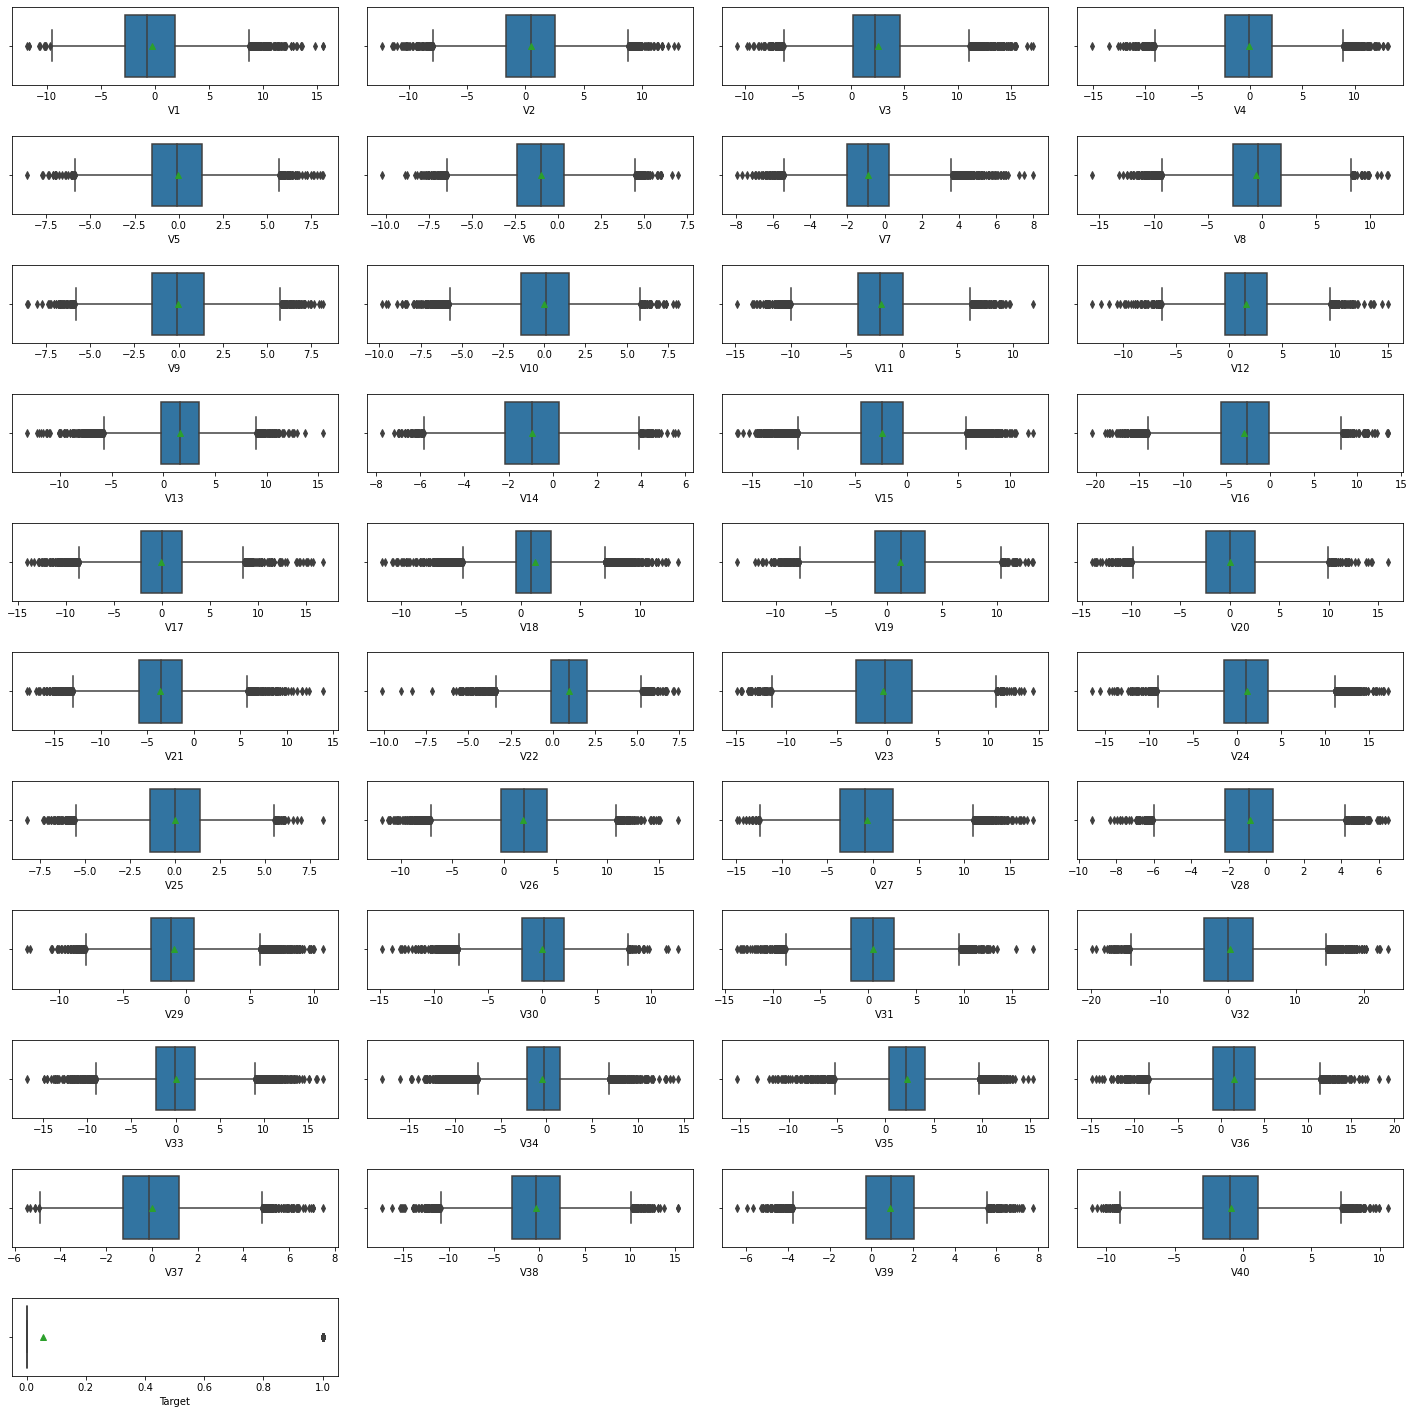

In [22]:
# outlier detection using boxplot
num_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(20,20))

nrows = math.ceil(len(num_cols)/4)
for i, variable in enumerate(num_cols):
    plt.subplot(nrows, 4, i + 1)
    sns.boxplot(data=df, x=variable, showmeans=True)
    plt.tight_layout(pad=2)

plt.show()

#### Observations
- The outliers look reasonable and we have no indication that they are questionable or erroneous. 

### Univariate Analysis

#### Let's investigate V1

count   19982.000
mean       -0.272
std         3.442
min       -11.876
25%        -2.737
50%        -0.748
75%         1.840
max        15.493
Name: V1, dtype: float64


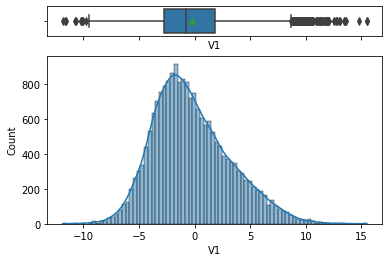

In [23]:
# Boxplot and Histplot for V1
output_pretty_numeric_plots(df, 'V1')

#### Observations
- Min for V1 is -11.876 and max is 15.493.
- Mean for V1 is -0.272 which is greater than the median indicating a right skew in the data.

#### Let's investigate V2

count   19982.000
mean        0.440
std         3.151
min       -12.320
25%        -1.641
50%         0.472
75%         2.544
max        13.089
Name: V2, dtype: float64


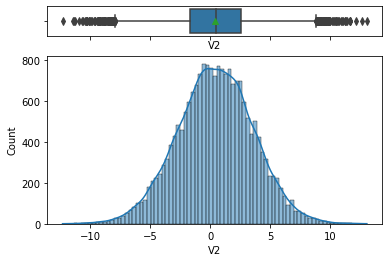

In [24]:
# Boxplot and Histplot for V2
output_pretty_numeric_plots(df, 'V2')

#### Observations
- Min for V2 is -12.320 and max is 13.089.
- Mean for V2 is .440 which is less than the median indicating a left skew in the data.

#### Let's investigate V3

count   20000.000
mean        2.485
std         3.389
min       -10.708
25%         0.207
50%         2.256
75%         4.566
max        17.091
Name: V3, dtype: float64


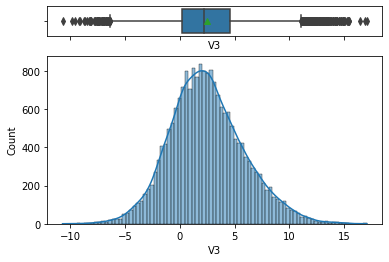

In [25]:
# Boxplot and Histplot for V3
output_pretty_numeric_plots(df, 'V3')

#### Observations
- Min for V3 is -10.708 and max is 17.091.
- Mean for V3 is 2.485 which is greater than the median indicating a right skew in the data.

#### Let's investigate V4

count   20000.000
mean       -0.083
std         3.432
min       -15.082
25%        -2.348
50%        -0.135
75%         2.131
max        13.236
Name: V4, dtype: float64


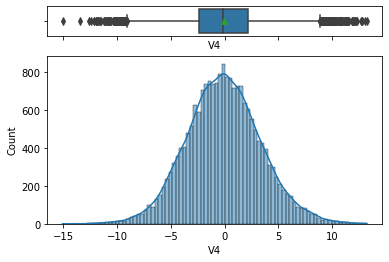

In [26]:
# Boxplot and Histplot for V4
output_pretty_numeric_plots(df, 'V4')

#### Observations
- Min for V4 is -15.082 and max is 13.236.
- Mean for V4 is -0.083 which is greater than the median indicating a right skew in the data.

#### Let's investigate V5

count   20000.000
mean       -0.054
std         2.105
min        -8.603
25%        -1.536
50%        -0.102
75%         1.340
max         8.134
Name: V5, dtype: float64


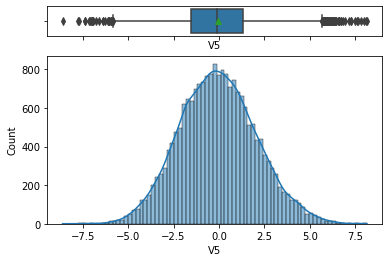

In [27]:
# Boxplot and Histplot for V5
output_pretty_numeric_plots(df, 'V5')

#### Observations
- Min for V5 is -8.603 and max is 8.134.
- Mean for V5 is -0.054 which is greater than the median indicating a right skew in the data.

#### Let's investigate V6

count   20000.000
mean       -0.995
std         2.041
min       -10.227
25%        -2.347
50%        -1.001
75%         0.380
max         6.976
Name: V6, dtype: float64


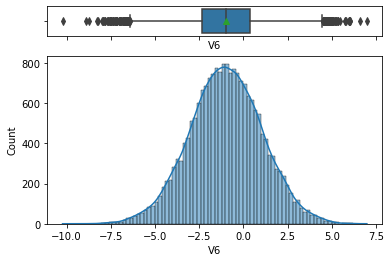

In [28]:
# Boxplot and Histplot for V6
output_pretty_numeric_plots(df, 'V6')

#### Observations
- Min for V6 is -10.227 and max is 6.976.
- Mean for V6 is -0.995 which is greater than the median indicating a right skew in the data.

#### Let's investigate V7

count   20000.000
mean       -0.879
std         1.762
min        -7.950
25%        -2.031
50%        -0.917
75%         0.224
max         8.006
Name: V7, dtype: float64


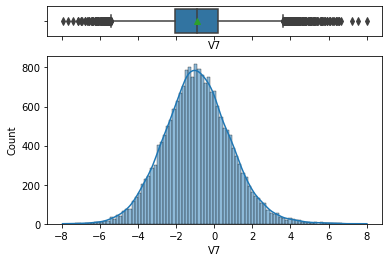

In [29]:
# Boxplot and Histplot for V7
output_pretty_numeric_plots(df, 'V7')

#### Observations
- Min for V7 is -7.950 and max is 8.006.
- Mean for V7  is -0.879 which is greater than the median indicating a right skew in the data.

#### Let's investigate V8

count   20000.000
mean       -0.548
std         3.296
min       -15.658
25%        -2.643
50%        -0.389
75%         1.723
max        11.679
Name: V8, dtype: float64


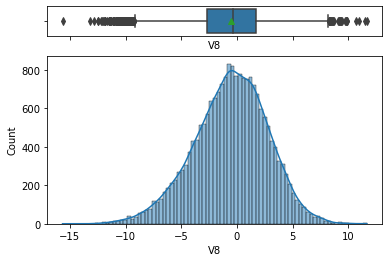

In [30]:
# Boxplot and Histplot for V8
output_pretty_numeric_plots(df, 'V8')

#### Observations
- Min for V8 is -15.658 and max is 11.679.
- Mean for V8 is -0.548 which is less than the median indicating a left skew in the data.

#### Let's investigate V9

count   20000.000
mean       -0.017
std         2.161
min        -8.596
25%        -1.495
50%        -0.068
75%         1.409
max         8.138
Name: V9, dtype: float64


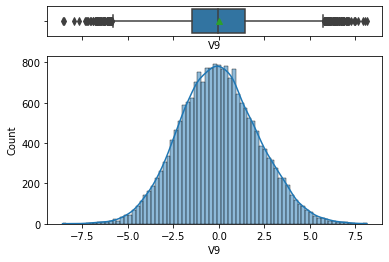

In [31]:
# Boxplot and Histplot for V9
output_pretty_numeric_plots(df, 'V9')

#### Observations
- Min for V9 is -8.596 and max is 8.138.
- Mean for V9 is -0.017 which is greater than the median indicating a right skew in the data.

#### Let's investigate V10

count   20000.000
mean       -0.013
std         2.193
min        -9.854
25%        -1.411
50%         0.101
75%         1.477
max         8.108
Name: V10, dtype: float64


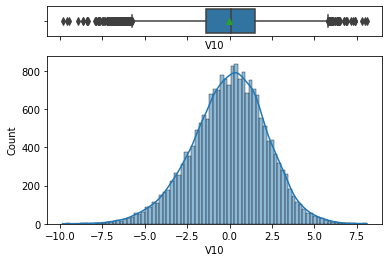

In [32]:
# Boxplot and Histplot for V10
output_pretty_numeric_plots(df, 'V10')

#### Observations
- Min for V10 is -9.854 and max is 8.108.
- Mean for V10 is -0.013 which is less than the median indicating a left skew in the data.

#### Let's investigate V11

count   20000.000
mean       -1.895
std         3.124
min       -14.832
25%        -3.922
50%        -1.921
75%         0.119
max        11.826
Name: V11, dtype: float64


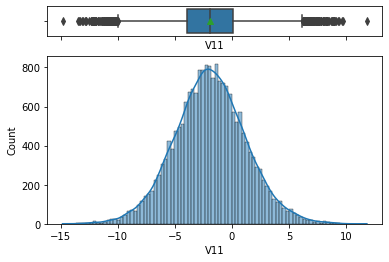

In [33]:
# Boxplot and Histplot for V11
output_pretty_numeric_plots(df, 'V11')

#### Observations
- Min for V11 is -14.832 and max is 11.826.
- Mean for V11 is -1.895 which is greater than the median indicating a right skew in the data.

#### Let's investigate V12

count   20000.000
mean        1.605
std         2.930
min       -12.948
25%        -0.397
50%         1.508
75%         3.571
max        15.081
Name: V12, dtype: float64


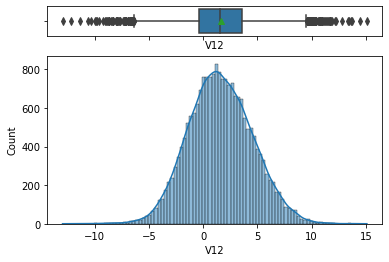

In [34]:
# Boxplot and Histplot for V12
output_pretty_numeric_plots(df, 'V12')

#### Observations
- Min for V12 is -12.948 and max is 15.081.
- Mean for V12 is 1.605 which is greater than the median indicating a right skew in the data.

#### Let's investigate V13

count   20000.000
mean        1.580
std         2.875
min       -13.228
25%        -0.224
50%         1.637
75%         3.460
max        15.420
Name: V13, dtype: float64


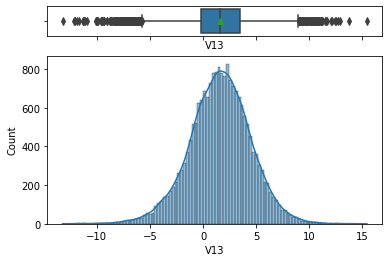

In [35]:
# Boxplot and Histplot for V13
output_pretty_numeric_plots(df, 'V13')

#### Observations
- Min for V13 is -13.228 and max is 15.420.
- Mean for V13 is 1.580 which is less than the median indicating a left skew in the data.

#### Let's investigate V14

count   20000.000
mean       -0.951
std         1.790
min        -7.739
25%        -2.171
50%        -0.957
75%         0.271
max         5.671
Name: V14, dtype: float64


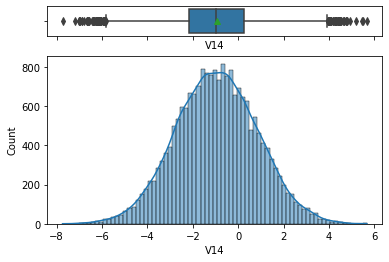

In [36]:
# Boxplot and Histplot for V14
output_pretty_numeric_plots(df, 'V14')

#### Observations
- Min for V14 is -7.739 and max is 5.671.
- Mean for V14 is -0.951 which is greater than the median indicating a right skew in the data.

#### Let's investigate V15

count   20000.000
mean       -2.415
std         3.355
min       -16.417
25%        -4.415
50%        -2.383
75%        -0.359
max        12.246
Name: V15, dtype: float64


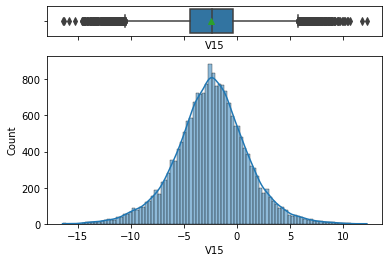

In [37]:
# Boxplot and Histplot for V15
output_pretty_numeric_plots(df, 'V15')

#### Observations
- Min for V15 is -16.417 and max is 12.246.
- Mean for V15 is -2.415 which is less than the median indicating a left skew in the data.

#### Let's investigate V16

count   20000.000
mean       -2.925
std         4.222
min       -20.374
25%        -5.634
50%        -2.683
75%        -0.095
max        13.583
Name: V16, dtype: float64


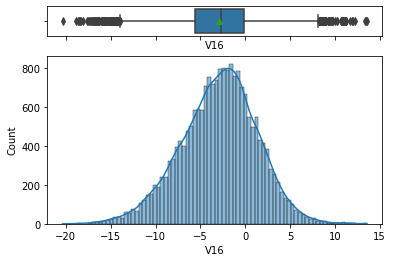

In [38]:
# Boxplot and Histplot for V16
output_pretty_numeric_plots(df, 'V16')

#### Observations
- Min for V16 is -20.374 and max is 13.583.
- Mean for V16 is -2.925 which is less than the median indicating a left skew in the data.

#### Let's investigate V17

count   20000.000
mean       -0.134
std         3.345
min       -14.091
25%        -2.216
50%        -0.015
75%         2.069
max        16.756
Name: V17, dtype: float64


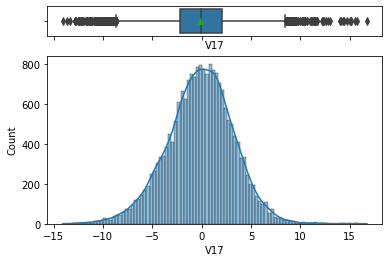

In [39]:
# Boxplot and Histplot for V17
output_pretty_numeric_plots(df, 'V17')

#### Observations
- Min for V17 is -14.091 and max is 16.756.
- Mean for V17 is -0.134 which is less than the median indicating a left skew in the data.

#### Let's investigate V18

count   20000.000
mean        1.189
std         2.592
min       -11.644
25%        -0.404
50%         0.883
75%         2.572
max        13.180
Name: V18, dtype: float64


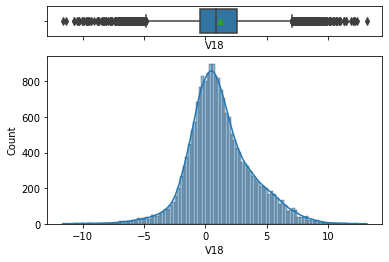

In [40]:
# Boxplot and Histplot for V18
output_pretty_numeric_plots(df, 'V18')

#### Observations
- Min for V18 is -11.644 and max is 13.180.
- Mean for V18 is 1.189 which is greater than the median indicating a right skew in the data.

#### Let's investigate V19

count   20000.000
mean        1.182
std         3.397
min       -13.492
25%        -1.050
50%         1.279
75%         3.493
max        13.238
Name: V19, dtype: float64


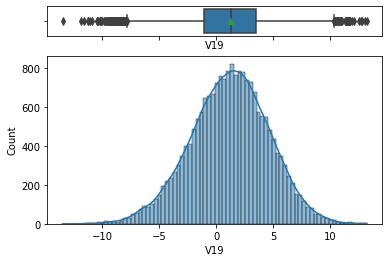

In [41]:
# Boxplot and Histplot for V19
output_pretty_numeric_plots(df, 'V19')

#### Observations
- Min for V19 is -13.492 and max is 13.238.
- Mean for V19 is 1.182 which is less than the median indicating a left skew in the data.

#### Let's investigate V20

count   20000.000
mean        0.024
std         3.669
min       -13.923
25%        -2.433
50%         0.033
75%         2.512
max        16.052
Name: V20, dtype: float64


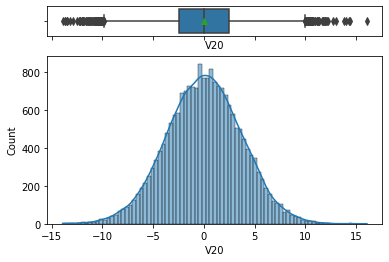

In [42]:
# Boxplot and Histplot for V20
output_pretty_numeric_plots(df, 'V20')

#### Observations
- Min for V20 is -13.923 and max is 16.052.
- Mean for V20 is 0.024 which is less than the median indicating a left skew in the data.

#### Let's investigate V21

count   20000.000
mean       -3.611
std         3.568
min       -17.956
25%        -5.930
50%        -3.533
75%        -1.266
max        13.840
Name: V21, dtype: float64


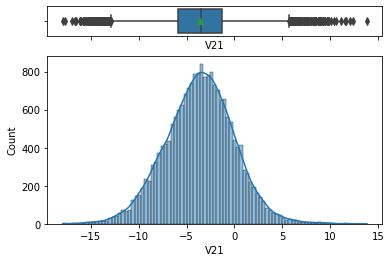

In [43]:
# Boxplot and Histplot for V21
output_pretty_numeric_plots(df, 'V21')

#### Observations
- Min for V21 is -17.956 and max is 13.840.
- Mean for V21 is -3.611 which is less than the median indicating a left skew in the data.

#### Let's investigate V22

count   20000.000
mean        0.952
std         1.652
min       -10.122
25%        -0.118
50%         0.975
75%         2.026
max         7.410
Name: V22, dtype: float64


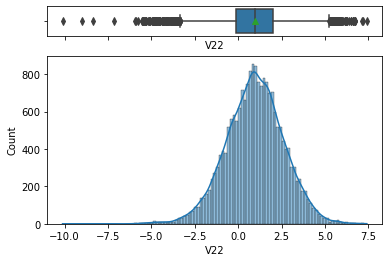

In [44]:
# Boxplot and Histplot for V22
output_pretty_numeric_plots(df, 'V22')

#### Observations
- Min for V22 is -10.122 and max is 7.410.
- Mean for V22 is 0.952 which is less than the median indicating a left skew in the data.

#### Let's investigate V23

count   20000.000
mean       -0.366
std         4.032
min       -14.866
25%        -3.099
50%        -0.262
75%         2.452
max        14.459
Name: V23, dtype: float64


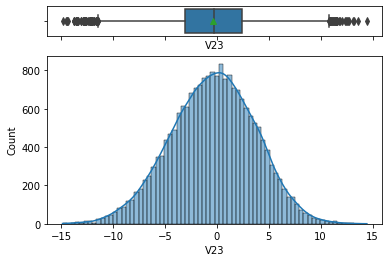

In [45]:
# Boxplot and Histplot for V23
output_pretty_numeric_plots(df, 'V23')

#### Observations
- Min for V23 is -14.866 and max is 14.459.
- Mean for V23 is -0.366 which is less than the median indicating a left skew in the data.

#### Let's investigate V24

count   20000.000
mean        1.134
std         3.912
min       -16.387
25%        -1.468
50%         0.969
75%         3.546
max        17.163
Name: V24, dtype: float64


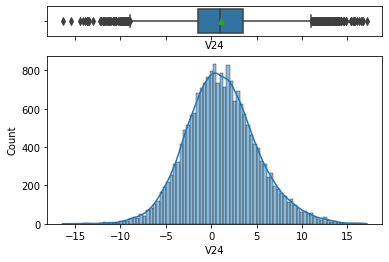

In [46]:
# Boxplot and Histplot for V24
output_pretty_numeric_plots(df, 'V24')

#### Observations
- Min for V24 is -16.387 and max is 17.163.
- Mean for V24 is 1.134 which is greater than the median indicating a right skew in the data.

#### Let's investigate V25

count   20000.000
mean       -0.002
std         2.017
min        -8.228
25%        -1.365
50%         0.025
75%         1.397
max         8.223
Name: V25, dtype: float64


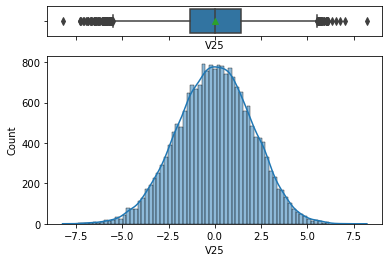

In [47]:
# Boxplot and Histplot for V25
output_pretty_numeric_plots(df, 'V25')

#### Observations
- Min for V25 is -8.228 and max is 8.223.
- Mean for V25 is -0.002 which is less than the median indicating a left skew in the data.

#### Let's investigate V26

count   20000.000
mean        1.874
std         3.435
min       -11.834
25%        -0.338
50%         1.951
75%         4.130
max        16.836
Name: V26, dtype: float64


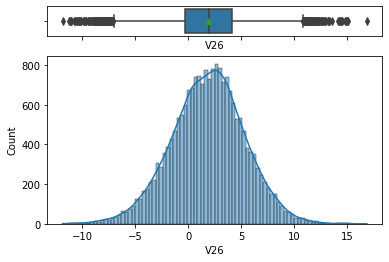

In [48]:
# Boxplot and Histplot for V26
output_pretty_numeric_plots(df, 'V26')

#### Observations
- Min for V26 is -11.834 and max is 16.836.
- Mean for V26 is 1.874 which is less than the median indicating a left skew in the data.

#### Let's investigate V27

count   20000.000
mean       -0.612
std         4.369
min       -14.905
25%        -3.652
50%        -0.885
75%         2.189
max        17.560
Name: V27, dtype: float64


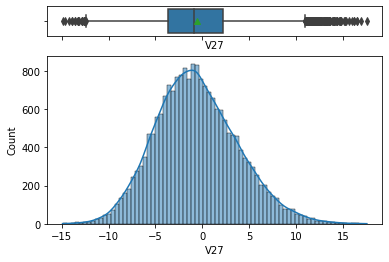

In [49]:
# Boxplot and Histplot for V27
output_pretty_numeric_plots(df, 'V27')

#### Observations
- Min for V27 is -14.905 and max is 17.560.
- Mean for V27 is -0.612 which is greater than the median indicating a right skew in the data.

#### Let's investigate V28

count   20000.000
mean       -0.883
std         1.918
min        -9.269
25%        -2.171
50%        -0.891
75%         0.376
max         6.528
Name: V28, dtype: float64


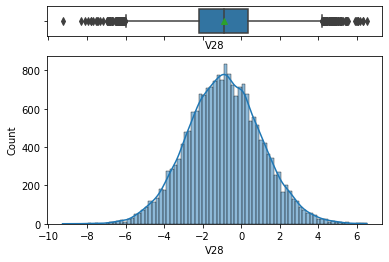

In [50]:
# Boxplot and Histplot for V28
output_pretty_numeric_plots(df, 'V28')

#### Observations
- Min for V28 is -9.269 and max is 6.528.
- Mean for V28 is -0.883 which is greater than the median indicating a right skew in the data.

#### Let's investigate V29

count   20000.000
mean       -0.986
std         2.684
min       -12.579
25%        -2.787
50%        -1.176
75%         0.630
max        10.722
Name: V29, dtype: float64


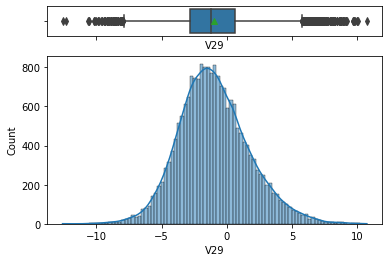

In [51]:
# Boxplot and Histplot for V29
output_pretty_numeric_plots(df, 'V29')

#### Observations
- Min for V29 is -12.579 and max is 10.722.
- Mean for V29 is -0.986 which is greater than the median indicating a right skew in the data.

#### Let's investigate V30

count   20000.000
mean       -0.016
std         3.005
min       -14.796
25%        -1.867
50%         0.184
75%         2.036
max        12.506
Name: V30, dtype: float64


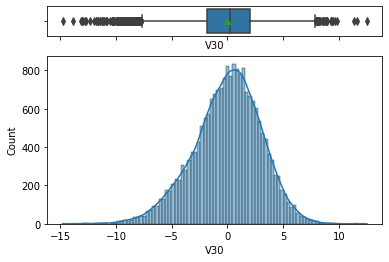

In [52]:
# Boxplot and Histplot for V30
output_pretty_numeric_plots(df, 'V30')

#### Observations
- Min for V30 is -14.796 and max is 12.506.
- Mean for V30 is -0.016 which is less than the median indicating a left skew in the data.

#### Let's investigate V31

count   20000.000
mean        0.487
std         3.461
min       -13.723
25%        -1.818
50%         0.490
75%         2.731
max        17.255
Name: V31, dtype: float64


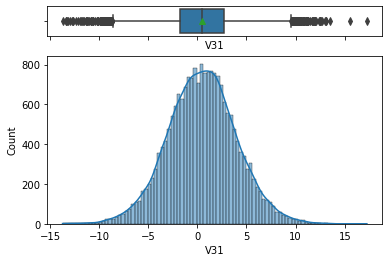

In [53]:
# Boxplot and Histplot for V31
output_pretty_numeric_plots(df, 'V31')

#### Observations
- Min for V31 is -13.723 and max is 17.255.
- Mean for V31 is 0.487 which is less than the median indicating a left skew in the data.

#### Let's investigate V32

count   20000.000
mean        0.304
std         5.500
min       -19.877
25%        -3.420
50%         0.052
75%         3.762
max        23.633
Name: V32, dtype: float64


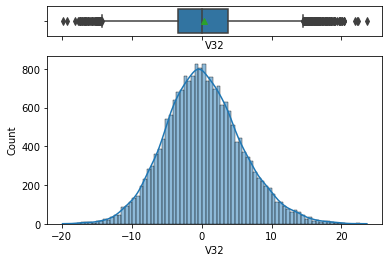

In [54]:
# Boxplot and Histplot for V32
output_pretty_numeric_plots(df, 'V32')

#### Observations
- Min for V32 is -19.877 and max is 23.633.
- Mean for V32 is 0.304 which is greater than the median indicating a right skew in the data.

#### Let's investigate V33

count   20000.000
mean        0.050
std         3.575
min       -16.898
25%        -2.243
50%        -0.066
75%         2.255
max        16.692
Name: V33, dtype: float64


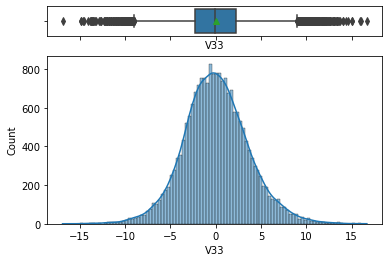

In [55]:
# Boxplot and Histplot for V33
output_pretty_numeric_plots(df, 'V33')

#### Observations
- Min for V33 is -16.898 and max is 16.692.
- Mean for V33 is 0.050 which is greater than the median indicating a right skew in the data.

#### Let's investigate V34

count   20000.000
mean       -0.463
std         3.184
min       -17.985
25%        -2.137
50%        -0.255
75%         1.437
max        14.358
Name: V34, dtype: float64


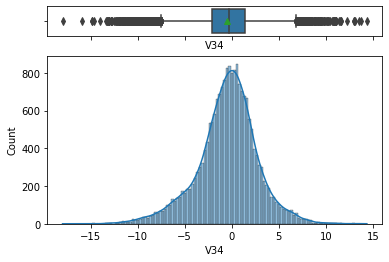

In [56]:
# Boxplot and Histplot for V34
output_pretty_numeric_plots(df, 'V34')

#### Observations
- Min for V34 is -17.985 and max is 14.358.
- Mean for V34 is -0.463 which is less than the median indicating a left skew in the data.

#### Let's investigate V35

count   20000.000
mean        2.230
std         2.937
min       -15.350
25%         0.336
50%         2.099
75%         4.064
max        15.291
Name: V35, dtype: float64


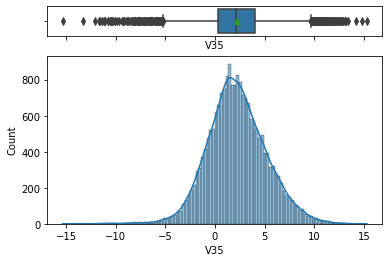

In [57]:
# Boxplot and Histplot for V35
output_pretty_numeric_plots(df, 'V35')

#### Observations
- Min for V35 is -15.350 and max is 15.291.
- Mean for V35 is 2.230 which is greater than the median indicating a right skew in the data.

#### Let's investigate V36

count   20000.000
mean        1.515
std         3.801
min       -14.833
25%        -0.944
50%         1.567
75%         3.984
max        19.330
Name: V36, dtype: float64


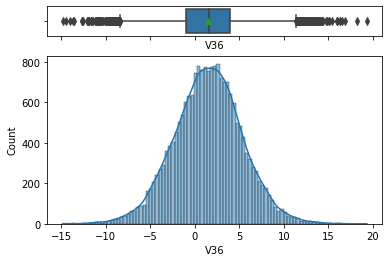

In [58]:
# Boxplot and Histplot for V36
output_pretty_numeric_plots(df, 'V36')

#### Observations
- Min for V36 is -14.833 and max is 19.330.
- Mean for V36 is 1.515 which is less than the median indicating a left skew in the data.

#### Let's investigate V37

count   20000.000
mean        0.011
std         1.788
min        -5.478
25%        -1.256
50%        -0.128
75%         1.176
max         7.467
Name: V37, dtype: float64


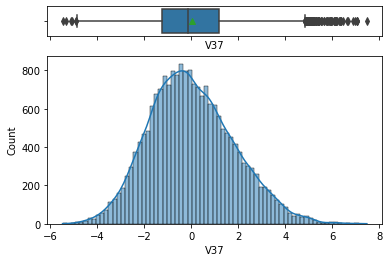

In [59]:
# Boxplot and Histplot for V37
output_pretty_numeric_plots(df, 'V37')

#### Observations
- Min for V37 is -5.478 and max is 7.467.
- Mean for V37 is 0.011 which is greater than the median indicating a right skew in the data.

#### Let's investigate V38

count   20000.000
mean       -0.344
std         3.948
min       -17.375
25%        -2.988
50%        -0.317
75%         2.279
max        15.290
Name: V38, dtype: float64


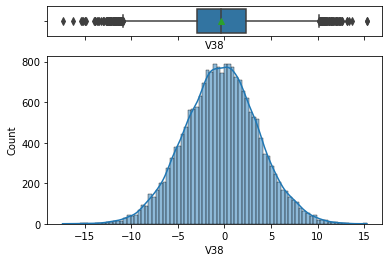

In [60]:
# Boxplot and Histplot for V38
output_pretty_numeric_plots(df, 'V38')

#### Observations
- Min for V38 is -17.375 and max is 15.290.
- Mean for V38 is -0.344 which is less than the median indicating a left skew in the data.

#### Let's investigate V39

count   20000.000
mean        0.891
std         1.753
min        -6.439
25%        -0.272
50%         0.919
75%         2.058
max         7.760
Name: V39, dtype: float64


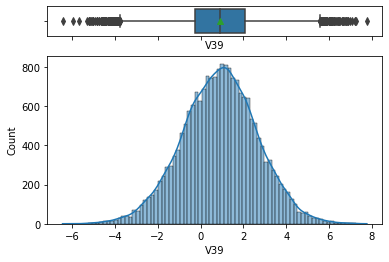

In [61]:
# Boxplot and Histplot for V39
output_pretty_numeric_plots(df, 'V39')

#### Observations
- Min for V39 is -6.439 and max is 7.760.
- Mean for V39 is 0.891 which is less than the median indicating a left skew in the data.

#### Let's investigate V40

count   20000.000
mean       -0.876
std         3.012
min       -11.024
25%        -2.940
50%        -0.921
75%         1.120
max        10.654
Name: V40, dtype: float64


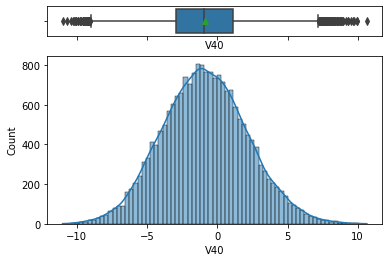

In [62]:
# Boxplot and Histplot for V40
output_pretty_numeric_plots(df, 'V40')

#### Observations
- Min for V40 is -11.024 and max is 10.654.
- Mean for V40 is -0.876 which is greater than the median indicating a right skew in the data.

#### Let's investigate Target

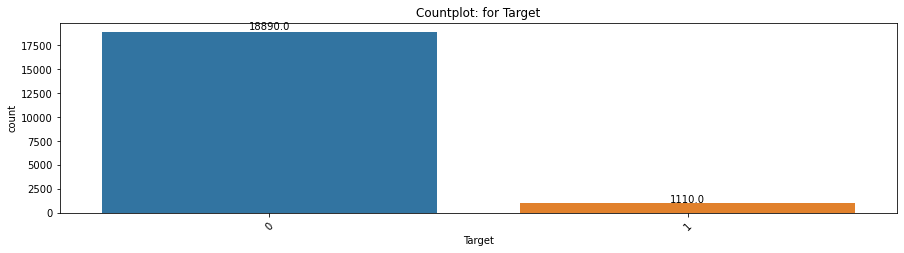

In [63]:
# Boxplot and Histplot for Target
output_pretty_countplot(df, 'Target')

#### Observations
- The majority of the values for Target (18890) the dependent variable are zero.

### Bivariate Analysis

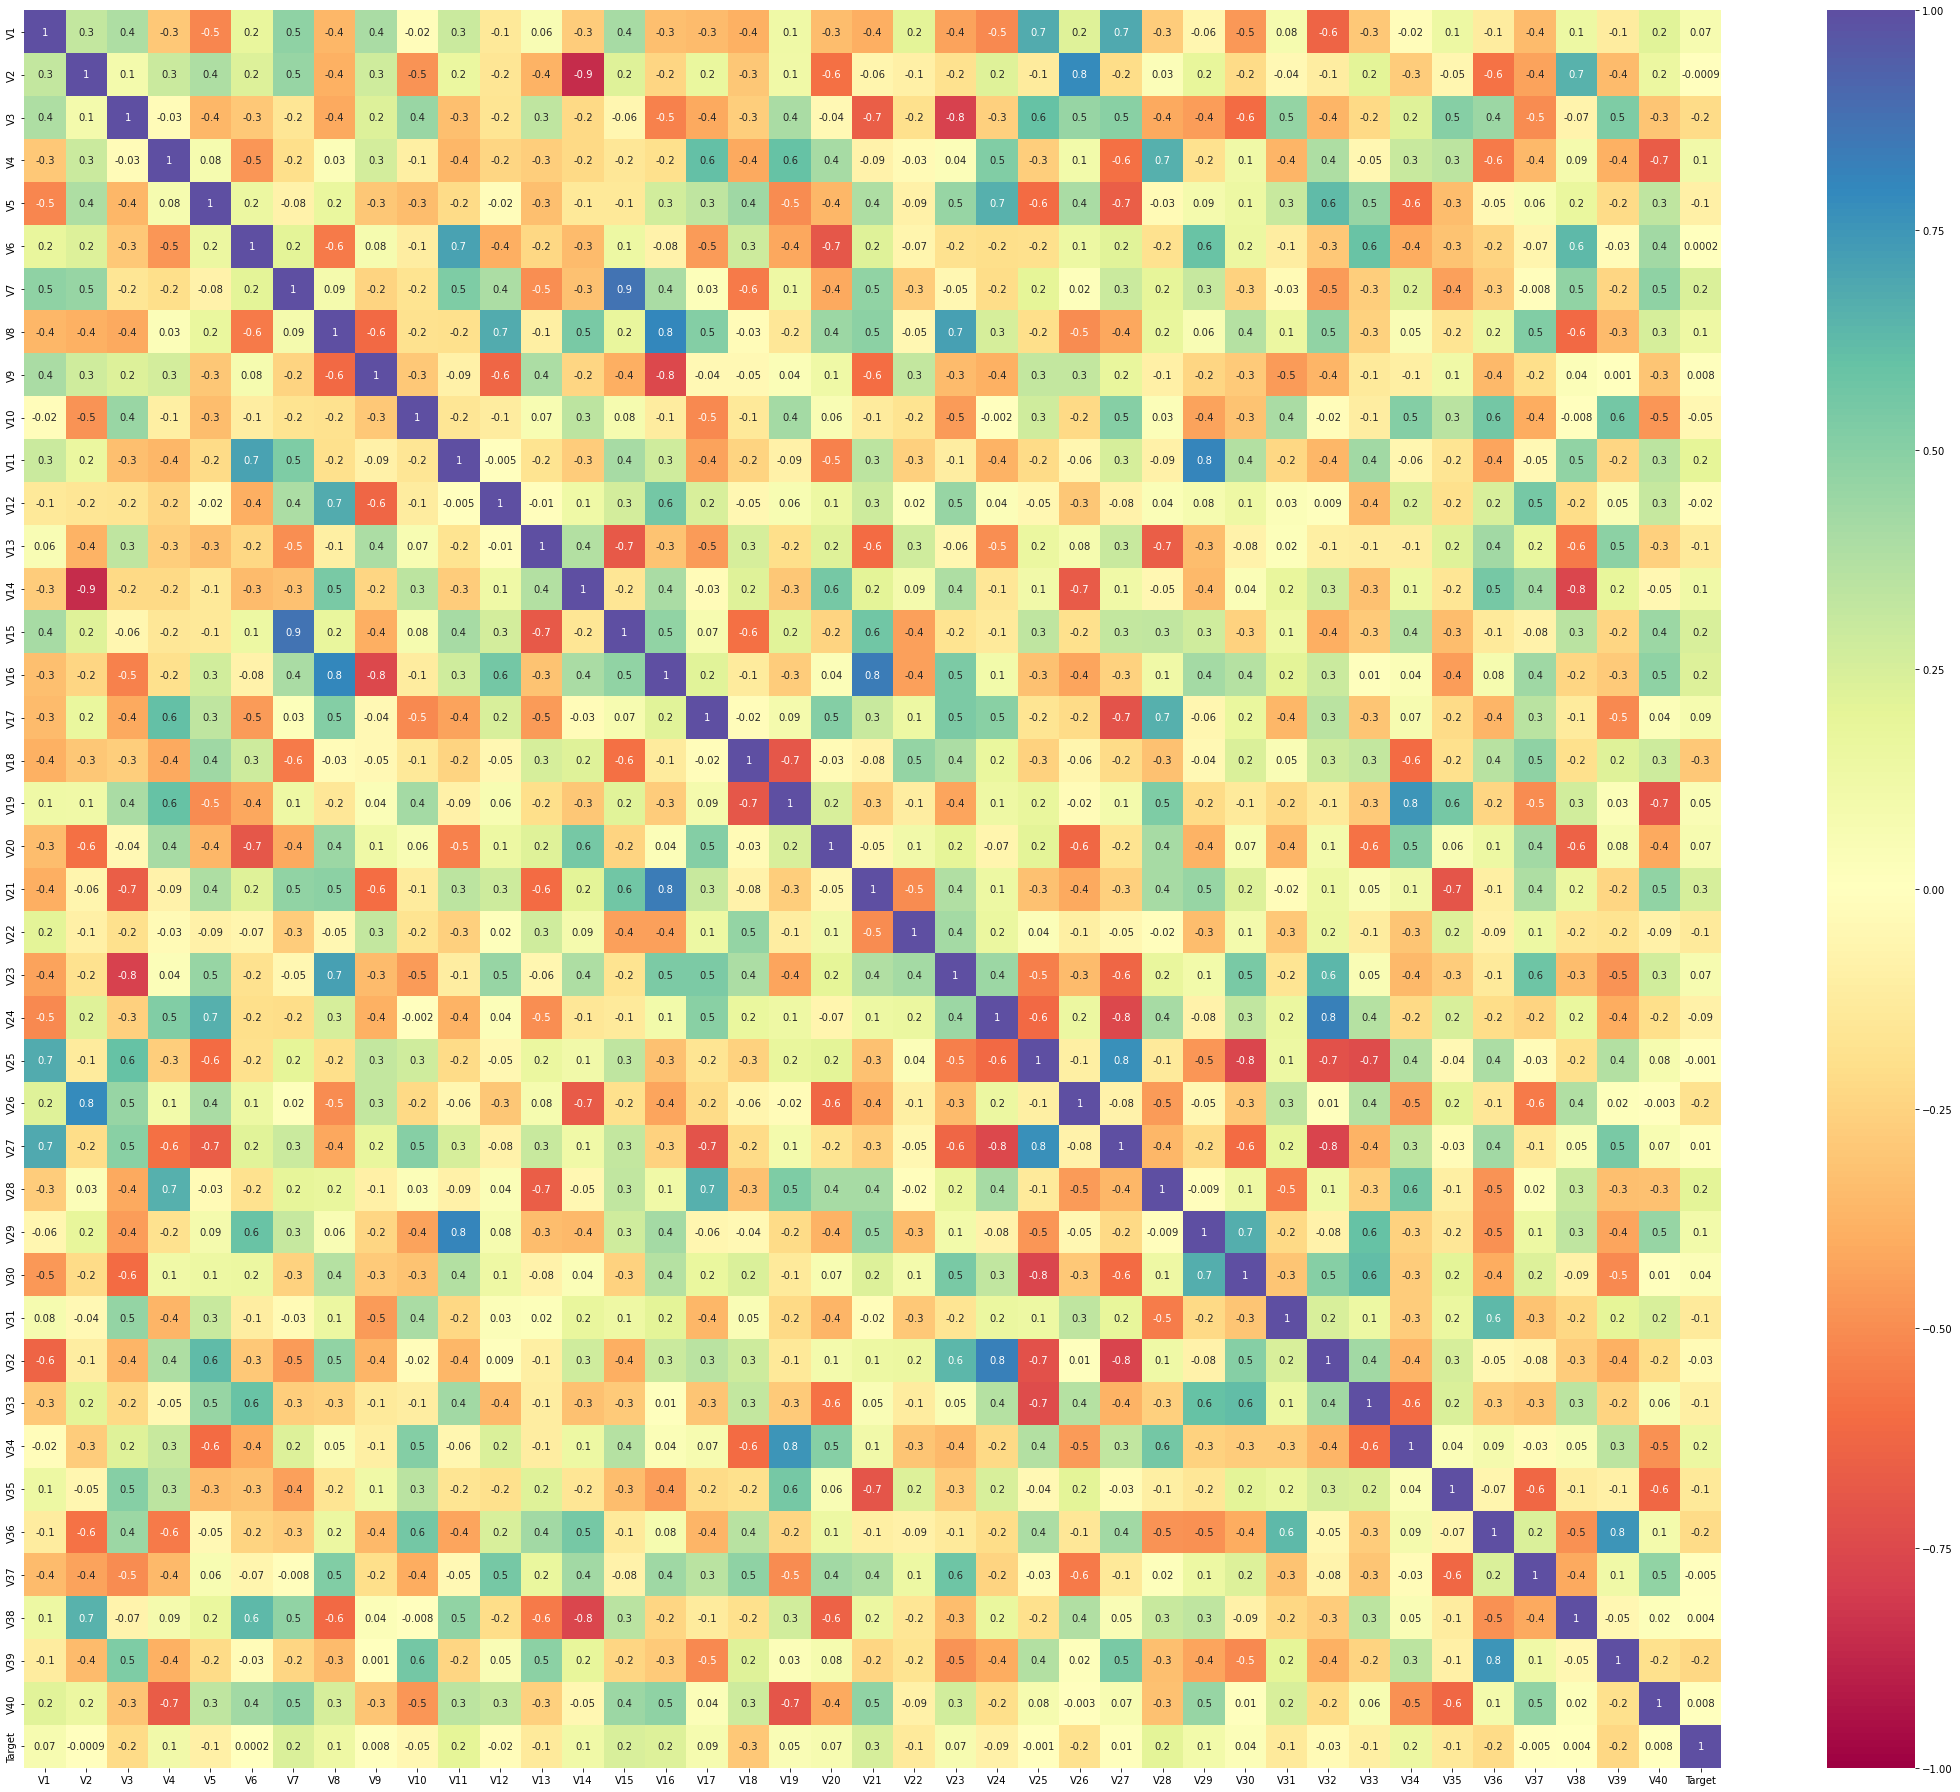

In [64]:
plt.figure(figsize=(30, 25))
sns.heatmap(
    df.corr(), annot=True, vmin=-1, vmax=1, fmt=".1g", cmap="Spectral"
)
plt.show()

In [65]:
corr_matrix = df.corr()
correlation = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                   .stack()
                   .reset_index(name='corr_value')
                   .sort_values(by='corr_value',ascending=False))

#### Observations
- The dependent variable has a very slight positive correlations with V21, V15, V7, V16 and V28 of 0.256,0.249,0.237,0.231 and 0.207 respectively.
- V7 has a positive correlation with V15 of 0.868
- V16 has a positive correlation with V21 of 0.837
- V24 has a positive correlation with V32 of 0.825
- V11 has a positive correlation with V29 of 0.811
- V8 has a positive correlation with V16 of 0.803
- V2 has a positive correlation with V26 of 0.787
- V25 has a positive correlation with V27 of 0.766
- V19 has a positive correlation with V34 of 0.756
- V36 has a positive correlation with V39 of 0.752


- V9 has a negative correlation with V16 of -0.753
- V24 has a negative correlation with V27 of -0.755
- V14 has a negative correlation with V38 of -0.763
- V25 has a negative correlation with V30 of -0.765
- V27 has a negative correlation with V32 of -0.766
- V3 has a negative correlation with V23 of -0.786
- V2 has a negative correlation with V14 of -0.854

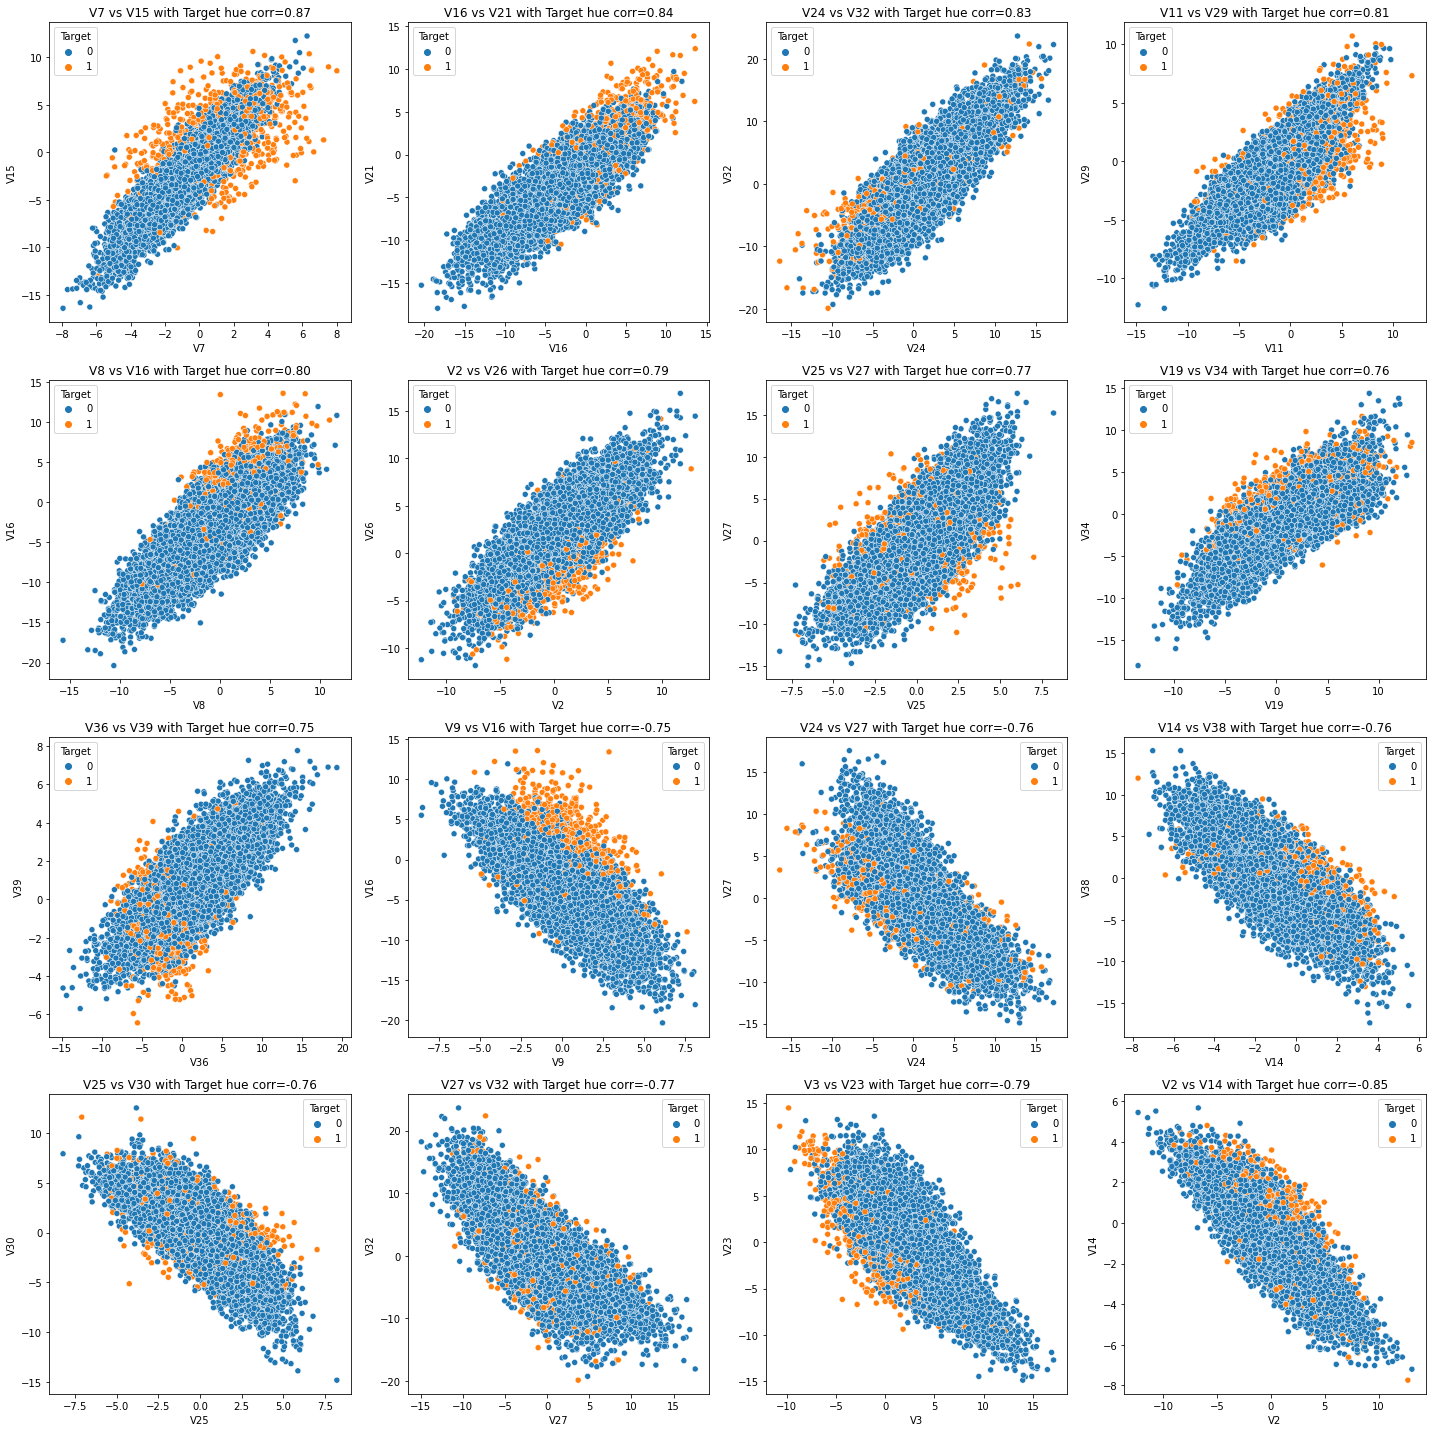

In [66]:
# Scatter plot all the high correlation relationships
vals = correlation[(correlation['corr_value'] >= .75) | (correlation['corr_value'] <= -.75)]\
                    [['level_0','level_1','corr_value']]
plt.figure(figsize=(20,20))
plots_per_row = 4

nrows = math.ceil(len(vals)/plots_per_row)
for i, (f1, f2, corr) in enumerate(zip(vals['level_0'].values, vals['level_1'].values, vals['corr_value'].values)):
    plt.subplot(nrows, plots_per_row, i + 1);
    output_pretty_scatterplot(df, f1, f2, hue='Target',\
                             title='{} vs {} with Target hue corr={:.2f}'.format(f1,f2,corr))

    plt.tight_layout(pad=2);
    
plt.show();

#### Observations
- V7/V15 with a positive correlation shows a reasonably clear distinction of the dependent variable around the edges of the scatter cloud and towards the top.
- V8/V16 with a positive correlation shows a reasonably clear distinction of the dependent variable around the upper edge of the scatter cloud.
- V9/V16 with a negative correlation shows a clear distinction of the dependent variable around the top edge of the scatter cloud.

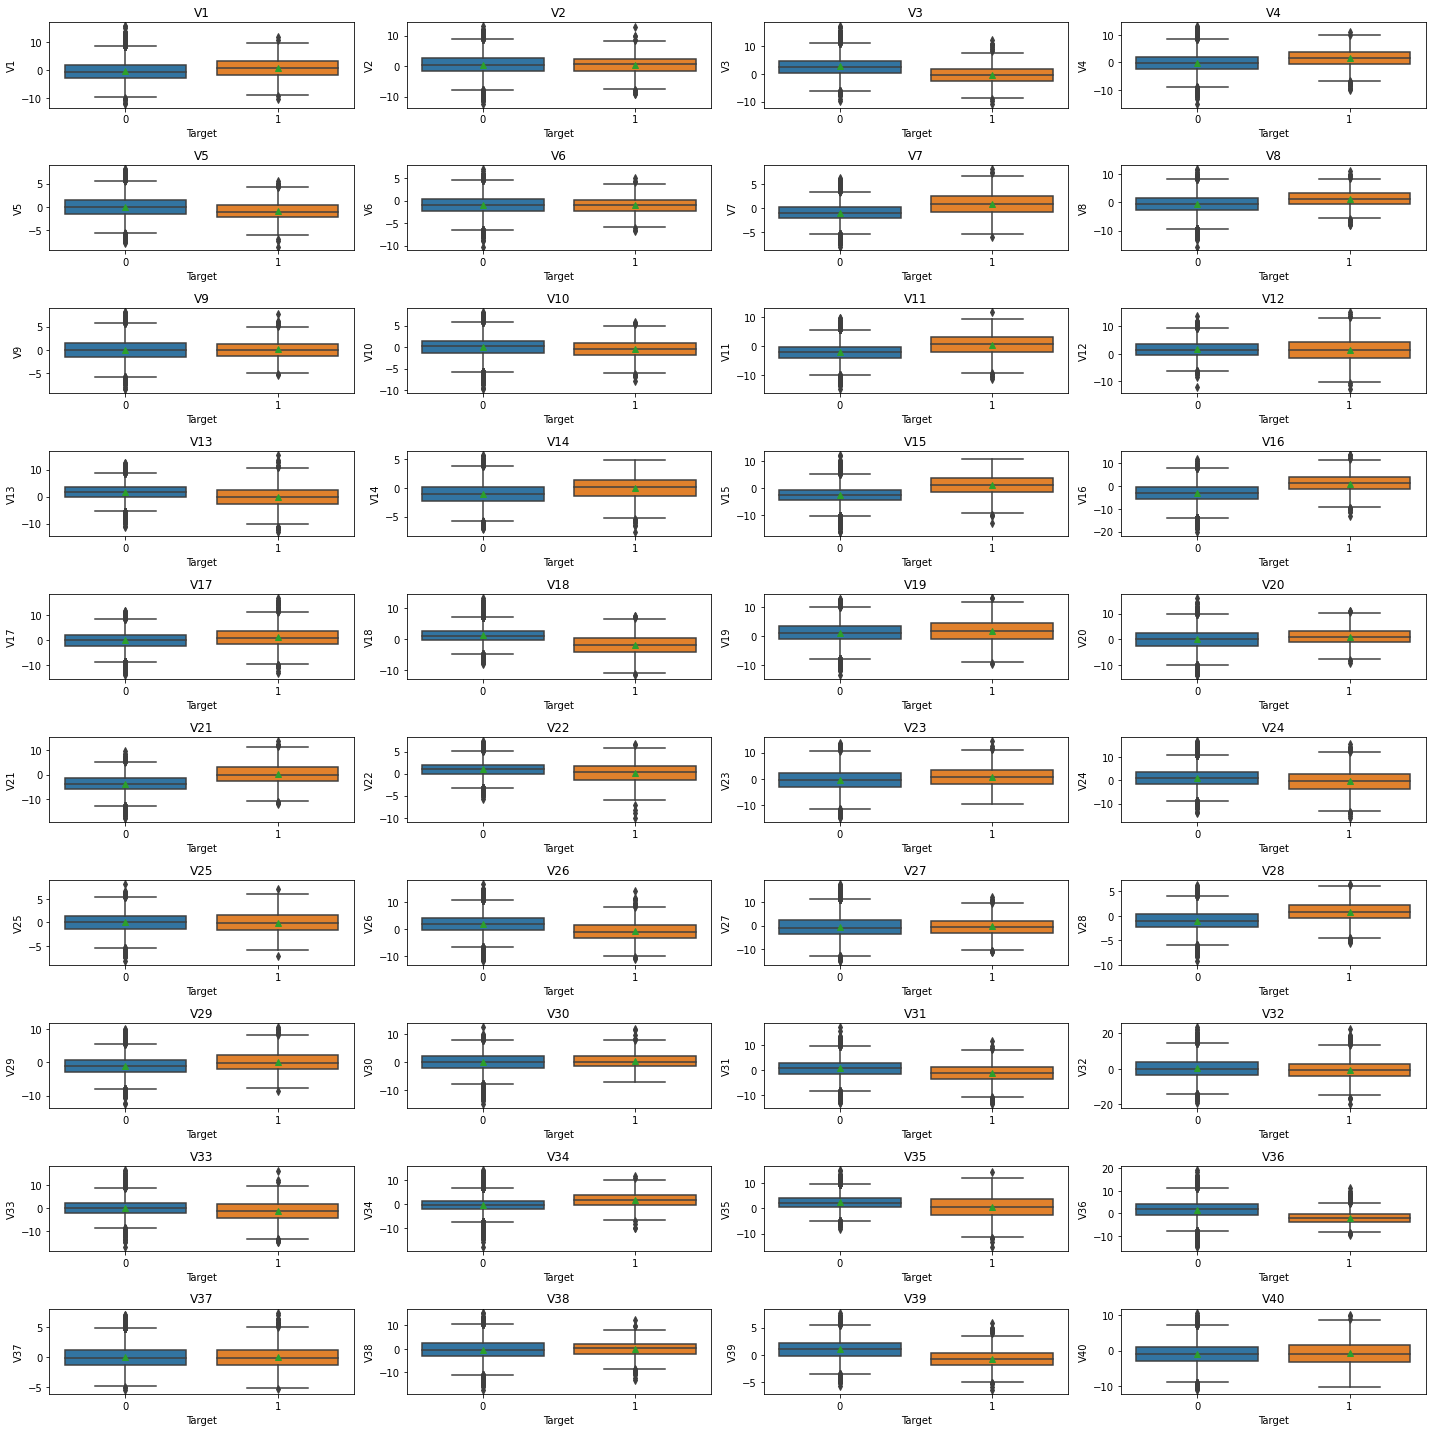

In [67]:
cols = data[
    [
        'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31',
       'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40'
    ]
].columns.tolist()
plots_per_row = 4
plt.figure(figsize=(20, 20))
nrows = math.ceil(len(cols)/plots_per_row)

for i, variable in enumerate(cols):
    plt.subplot(nrows, plots_per_row, i + 1);
    sns.boxplot(data["Target"], data[variable], showmeans=True)
    plt.tight_layout()
    plt.title(variable)
plt.show()

#### Observations
- For the dependent variable Target with a value of 1 (failure) V3, V18, V26, V31, V36, V39 generally show lower values than for Target equal to 0.
- For the dependent variable Target with a value of 1 (failure) V4, V7, V8, V11, V14, V15, V16, V21, V28, V29, V34 generally show higher values than for Target equal to 0.

## Data Pre-processing

In [68]:
X = df.drop(["Target"], axis=1)
Y = df["Target"]

# creating dummy variables
X = pd.get_dummies(X, drop_first=True)

# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

x_train, x_val, y_train, y_val= train_test_split(
    X, Y, test_size=0.20, random_state=1, stratify=Y
)

x_test = df_test.drop(["Target"], axis=1)
y_test = df_test["Target"]

print("Number of rows in train data={}, validation data={}, test data={}".format(x_train.shape[0],\
         x_val.shape[0], x_test.shape[0]))

Number of rows in train data=16000, validation data=4000, test data=5000


## Missing value imputation and scaling

In [69]:
# creating an instance of the imputer and standard scaler to be used
imputer = SimpleImputer(strategy="median")
scale = StandardScaler()

In [70]:
# Fit and transform the train data
x_train_tr = imputer.fit_transform(x_train)
x_train_tr = scale.fit_transform(x_train_tr)
x_train = pd.DataFrame(x_train_tr, columns=x_train.columns)

# Transform the validation data
x_val_tr = imputer.transform(x_val)
x_val_tr = scale.transform(x_val_tr)
x_val = pd.DataFrame(x_val_tr, columns=x_val.columns) 

# Transform the test data
x_test_tr = imputer.transform(x_test)
x_test_tr = scale.transform(x_test_tr)
x_test = pd.DataFrame(x_test_tr, columns=x_test.columns) 

In [71]:
# Checking that no column has missing values in train, validation or test sets
print(x_train.isna().sum())
print("-" * 30)
print(x_val.isna().sum())
print("-" * 30)
print(x_test.isna().sum())
print("-" * 30)

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

#### Observations
- After imputation there are no null values for train, validation or test.

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [72]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data


Cross-Validation performance on training dataset:

dtree: 0.7196280073636767
Bagging: 0.7083222243382213
AdaBoost: 0.6215641465117756
GB: 0.7173363803719928
RandomForest: 0.7195899193804354
XGB: 0.810804291246112
LGBM: 0.8062972132292261

Validation Performance:

dtree: 0.7387387387387387
Bagging: 0.7207207207207207
AdaBoost: 0.6576576576576577
GB: 0.7432432432432432
RandomForest: 0.7432432432432432
XGB: 0.8153153153153153
LGBM: 0.8108108108108109


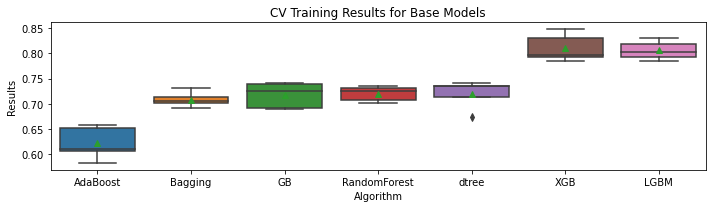

In [73]:
# Create models for DecisionTreeClassifier, BaggingClassifier,AdaBoostClassifier, GradientBoostingClassifier,
# RandomForestClassifier,XGBClassifier, and LGBMClassifier
base_models = create_base_models()
base_models, results_df, results_val_df = validate_fit_and_score(base_models, x_train, y_train, x_val, scorer,\
                                                                'CV Training Results for Base Models')

In [74]:
output_model_comparison(results_df, results_val_df)

,Algorithm,% Diff between Training and Validation Recall,Validation
5,XGB,0.493,81.532
6,LGBM,0.620,81.081
3,GB,3.626,74.324
4,RandomForest,3.194,74.324
0,dtree,2.639,73.874
1,Bagging,1.836,72.072
2,AdaBoost,5.788,65.766


#### Observations
- XGB had the best validation recall score of 81.532 which was .493% higher than the training score.
- The top three recall validation results with the original data are: XGB, LGBM and GB.
- The bottom three recall validation results with the original data are: dtree, Bagging and AdaBoost
- dtree has outliers.

### Model Building with Oversampled data


In [75]:
print("Before Oversampling, counts of label 'Yes': {} 'No': {}".format(sum(y_train == 1),\
                                                                      sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
x_train_over, y_train_over = sm.fit_resample(x_train, y_train)

print("After Oversampling, counts of label 'Yes': {}  'No': {}".format(sum(y_train_over == 1),\
                                                                      sum(y_train_over == 0)))
print("After Oversampling, the shape of train_X: {} train_y: {}".format(x_train_over.shape,\
                                                                       y_train_over.shape))

Before Oversampling, counts of label 'Yes': 888 'No': 15112
After Oversampling, counts of label 'Yes': 15112  'No': 15112
After Oversampling, the shape of train_X: (30224, 40) train_y: (30224,)



Cross-Validation performance on training dataset:

dtree: 0.97386180907768
Bagging: 0.9765087122705628
AdaBoost: 0.8932637557240944
GB: 0.9210559765381359
RandomForest: 0.9840525089688519
XGB: 0.9898095628200562
LGBM: 0.9811407271803008

Validation Performance:

dtree: 0.8108108108108109
Bagging: 0.8243243243243243
AdaBoost: 0.8603603603603603
GB: 0.8738738738738738
RandomForest: 0.8648648648648649
XGB: 0.8423423423423423
LGBM: 0.8738738738738738


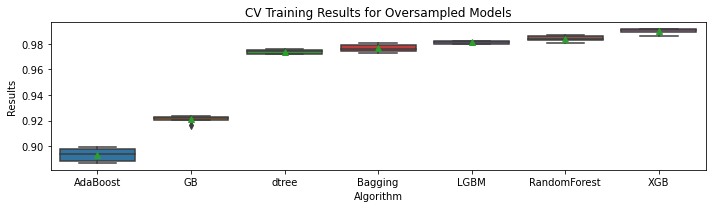

In [76]:
# Create models for DecisionTreeClassifier, BaggingClassifier,AdaBoostClassifier, GradientBoostingClassifier,
# RandomForestClassifier,XGBClassifier, and LGBMClassifier
oversample_models = create_base_models()
oversample_models, results_over_df, results_over_val_df = validate_fit_and_score(oversample_models, x_train_over, \
                                                                        y_train_over, x_val, scorer,\
                                                                        'CV Training Results for Oversampled Models')

In [77]:
output_model_comparison(results_over_df, results_over_val_df)

,Algorithm,% Diff between Training and Validation Recall,Validation
3,GB,-5.103,87.387
6,LGBM,-10.907,87.387
4,RandomForest,-12.093,86.486
2,AdaBoost,-3.695,86.036
5,XGB,-14.949,84.234
1,Bagging,-15.660,82.432
0,dtree,-16.735,81.081


#### Observations
- GB had the best validation recall score of 87.387 which was 5.103% lower than the training score.
- The top three recall validation results with the oversampled data are: GB, LGBM and RandomForest and all beat the top three recall scores using the original data.
- The bottom three recall validation results with the oversampled data are: XGB, Bagging and dtree.
- GB has outliers.

### Model Building with Undersampled data

In [78]:
print("Before UnderSampling, counts of label '1': {} '0': {}".format(sum(y_train == 1),\
                                                                    sum(y_train == 0)))
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
x_train_un, y_train_un = rus.fit_resample(x_train, y_train)

print("After UnderSampling, counts of label '1': {} '0': {}".format(sum(y_train_un == 1),\
                                                                   sum(y_train_un == 0)))
print("After UnderSampling, the shape of train_X: {} train_y: {}".format(x_train_un.shape,\
                                                                        y_train_un.shape))

Before UnderSampling, counts of label '1': 888 '0': 15112
After UnderSampling, counts of label '1': 888 '0': 888
After UnderSampling, the shape of train_X: (1776, 40) train_y: (1776,)



Cross-Validation performance on training dataset:

dtree: 0.8468355233923697
Bagging: 0.8704627689963816
AdaBoost: 0.8715927124992063
GB: 0.8907446200723672
RandomForest: 0.8975052370976957
XGB: 0.8930108550752237
LGBM: 0.8930108550752237

Validation Performance:

dtree: 0.8468468468468469
Bagging: 0.8918918918918919
AdaBoost: 0.8558558558558559
GB: 0.8873873873873874
RandomForest: 0.8783783783783784
XGB: 0.8918918918918919
LGBM: 0.8873873873873874


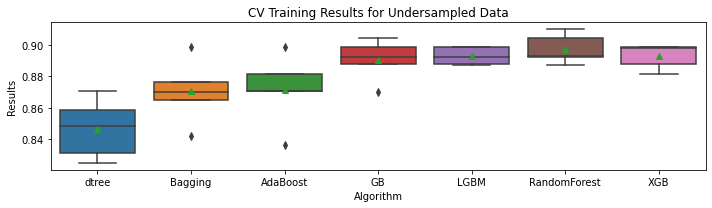

In [79]:
# Create models for DecisionTreeClassifier, BaggingClassifier,AdaBoostClassifier, GradientBoostingClassifier,
# RandomForestClassifier,XGBClassifier, and LGBMClassifier
undersample_models = create_base_models()
undersample_models, results_under_df, results_under_val_df = validate_fit_and_score(undersample_models, x_train_un, \
                                                                            y_train_un, x_val, scorer,\
                                                                            'CV Training Results for Undersampled Data')

In [80]:
output_model_comparison(results_under_df, results_under_val_df)

,Algorithm,% Diff between Training and Validation Recall,Validation
1,Bagging,2.529,89.189
5,XGB,-0.112,89.189
3,GB,-0.449,88.739
6,LGBM,-0.672,88.739
4,RandomForest,-2.227,87.838
2,AdaBoost,-1.835,85.586
0,dtree,0.000,84.685


#### Observations
- Bagging, XGB had the best validation recall score of 89.189 which was 2.529% higher than the Bagging training score for and -0.112% lower than the XGB training score and are the best validation recall scores thus far.
- The top three recall validation results with the undersampled data are: Bagging, XGB and GB. These top three oversampled validation recall scores beat undersampled and orginal data top three models.
- The bottom three recall validation results with the undersampled data are: RandomForest, AdaBoost and dtree.
- Bagging, AdaBoost and GB outliers.


- Moving forward to hyper-parameter tuning I choose Bagging Undersampled, XGB Undersampled, GB undersampled, LGBM undersampled based on their excellent validation recall scores.

## HyperparameterTuning 

In [81]:
# Create dictionaries to capture results.
model_training_results = {}
model_validation_results = {}
model_testing_results = {}

### Tuning method for Bagging with undersampled data

In [82]:
# defining model
model = BaggingClassifier(random_state=1)
     
#Parameter grid to pass in RandomSearchCV
param_grid = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50,60],
             }
randomized_cv = search_for_best_parms(model, param_grid, x_train_un, y_train_un)

Best parameters are {'n_estimators': 50, 'max_samples': 0.8, 'max_features': 0.7, 'random_state': 1} with CV score=0.8941915825557037:


Training Performance:


,Accuracy,Recall,Precision,F1
0,0.995,0.991,1.000,0.995


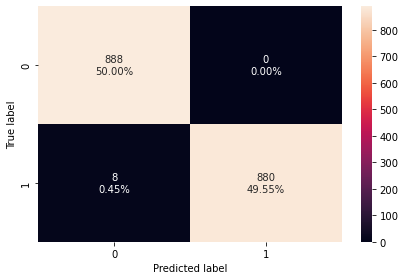

In [83]:
# Build a new classifier based on the best parms from the search
tuned_bagging_under = BaggingClassifier(**randomized_cv.best_params_)
tuned_bagging_under.fit(x_train_un, y_train_un)
calculate_performance(tuned_bagging_under, x_train_un, y_train_un, model_training_results, 'tuned bagging under', \
                      train=True)

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.940,0.878,0.477,0.618


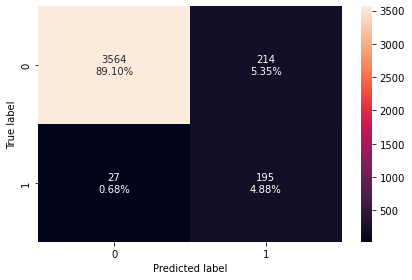

In [84]:
calculate_performance(tuned_bagging_under, x_val, y_val, model_validation_results, 'tuned bagging under')

#### Observations
- After hypertuning the BaggingClassifier validation recall declined 1.55% to .878 and the training recall increased about 13.9% from the undersampled data results indicating a slight overfit. Precision is very high for training but decreased significantly with the validation data. 
- Given the validation recall did not increase and the generalizability of the model dropped a bit lets look at other hypertuning possibilities. 

### Tuning method for LGBMClassifier with undersampled data

In [85]:
# defining model
model = lgb.LGBMClassifier(random_state=1)
     
#Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(3,8),\
               'num_leaves': np.arange(2,20),\
               'feature_fraction': [.7,.8,.9],\
               'bagging_freq': [4,5,6],
               'bagging_fraction': np.arange(.6, .85),\
               'lambda_l2':np.arange(2,20,2)}

randomized_cv = search_for_best_parms(model, param_grid, x_train_un, y_train_un)

Best parameters are {'num_leaves': 14, 'max_depth': 4, 'lambda_l2': 8, 'feature_fraction': 0.8, 'bagging_freq': 4, 'bagging_fraction': 0.6, 'random_state': 1} with CV score=0.9020630990922364:


Training Performance:


,Accuracy,Recall,Precision,F1
0,0.959,0.927,0.992,0.958


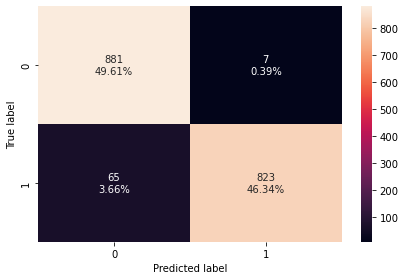

In [86]:
# Build a new classifier based on the best parms from the search
tuned_lgbm_under = lgb.LGBMClassifier(**randomized_cv.best_params_)
tuned_lgbm_under.fit(x_train_un, y_train_un)
calculate_performance(tuned_lgbm_under, x_train_un, y_train_un, model_training_results, 'tuned lgbm under', train=True)

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.942,0.892,0.489,0.632


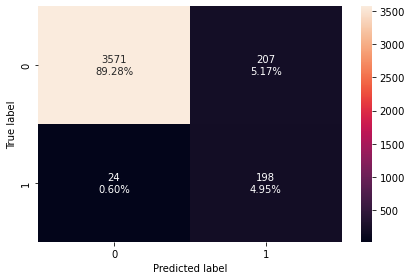

In [87]:
calculate_performance(tuned_lgbm_under, x_val, y_val, model_validation_results, 'tuned lgbm under')

#### Observations
- After hypertuning the LGBMClassifier validation recall increased .529% to .892 and the training recall increased about 3.80% from the undersampled data results. Precision is very high for training but decreased significantly with the validation data. 
- Given the validation recall did increase and the model is generalizable we will keep this model under consideration.

### Tuning method for GradientBoostingClassifier with undersampled data

In [88]:
# defining model
model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid={
    "n_estimators": np.arange(100,150,25),
    "learning_rate": np.linspace(.01, .1),
    "subsample": np.linspace(.3,.7), 
    "max_features":[0.5,0.7]}

randomized_cv = search_for_best_parms(model, param_grid, x_train_un, y_train_un)

Best parameters are {'subsample': 0.536734693877551, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.0963265306122449, 'random_state': 1} with CV score=0.8953151780613217:


Training Performance:


,Accuracy,Recall,Precision,F1
0,0.959,0.940,0.977,0.958


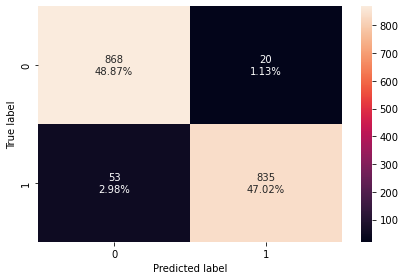

In [89]:
# Build a new classifier based on the best parms from the search
tuned_gb_under = GradientBoostingClassifier(**randomized_cv.best_params_)
tuned_gb_under.fit(x_train_un, y_train_un)
calculate_performance(tuned_gb_under, x_train_un, y_train_un, model_training_results, 'tuned gb under', train=True)

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.924,0.887,0.414,0.564


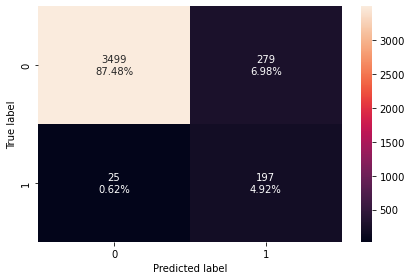

In [90]:
calculate_performance(tuned_gb_under, x_val, y_val, model_validation_results, 'tuned gb under')

#### Observations
- After hyper-tuning GradientBoostingClassifier the training recall increased 5.53% and the validation recall decreased by .043% to .887 from the oversampled results. Precision is very high for training but decreased significantly with the validation data. 
- Given the validation recall did not increase lets look at other hypertuning possibilities.  

### Tuning method for XGBClassifier with undersampled data

In [91]:
###### defining model
model = XGBClassifier(random_state=1, eval_metric='logloss')

# Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators': np.arange(50,150,50),\
               'scale_pos_weight':[1,3,3.5],\
               'learning_rate': np.linspace(.005,.09),\
               'gamma': np.linspace(1,6),\
               'reg_lambda':np.linspace(2,4),\
               'max_depth':np.arange(2,5,1),\
               'subsample':[0.7, 0.8,0.9]}
                
randomized_cv = search_for_best_parms(model, param_grid, x_train_un, y_train_un, \
                                      extra_cv_parms={'random_state': 1, 'eval_metric': 'logloss'})

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 3, 'reg_lambda': 3.224489795918367, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.01020408163265306, 'gamma': 1.306122448979592, 'random_state': 1, 'eval_metric': 'logloss'} with CV score=0.9324636577159906:


Training Performance:


,Accuracy,Recall,Precision,F1
0,0.801,0.937,0.736,0.825


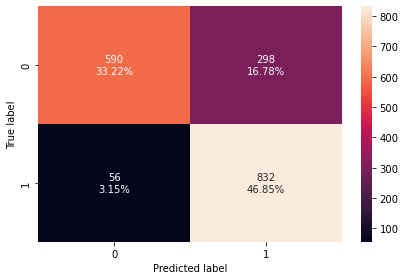

In [92]:
# Build a new classifier based on the best parms from the search
tuned_xgb_under = XGBClassifier(**randomized_cv.best_params_)
tuned_xgb_under.fit(x_train_un, y_train_un)
calculate_performance(tuned_xgb_under, x_train_un, y_train_un, model_training_results, 'tuned xgb under', train=True)

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.656,0.928,0.132,0.230


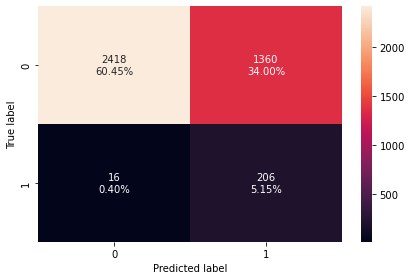

In [93]:
calculate_performance(tuned_xgb_under, x_val, y_val, model_validation_results, 'tuned xgb under')

#### Observations
- After hyper-tuning XGBClassifier the training recall increased 4.92% and the validation recall increased by 4.04% to .928 from the undersampled results. Precision is reasonable for training but decreased significantly with the validation data. 
- This is now our highest validation recall score and the model seems to be generalizable. 

## Model performance comparison and choosing the final model

In [94]:
models_train_comp_df = pd.concat(model_training_results.values(), axis=1)
models_train_comp_df.columns = list(model_training_results.keys())
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,tuned bagging under,tuned lgbm under,tuned gb under,tuned xgb under
Accuracy,0.995,0.959,0.959,0.801
Recall,0.991,0.927,0.940,0.937
Precision,1.000,0.992,0.977,0.736
F1,0.995,0.958,0.958,0.825


In [95]:
models_validation_comp_df = pd.concat(model_validation_results.values(), axis=1)
models_validation_comp_df.columns = list(model_validation_results.keys())
print("Validation performance comparison:")
models_validation_comp_df

Validation performance comparison:


,tuned bagging under,tuned lgbm under,tuned gb under,tuned xgb under
Accuracy,0.940,0.942,0.924,0.656
Recall,0.878,0.892,0.887,0.928
Precision,0.477,0.489,0.414,0.132
F1,0.618,0.632,0.564,0.230


In [96]:
output_model_differences(models_train_comp_df.columns, models_train_comp_df, models_validation_comp_df)

,Algorithm,% Diff between Training and Validation Recall,Validation
3,tuned xgb under,-0.961,92.793
1,tuned lgbm under,-3.776,89.189
2,tuned gb under,-5.638,88.739
0,tuned bagging under,-11.403,87.838


### [Conceptual cost calculations](#cost_calculation)

The two top models based on validation recall score and generalizabilty are tuned xgb under and tuned lgbm under. The tuned xgb under model has a validation recall that is 4.04% higher than the tuned lgbm under however it does not perform well from a precision perspective. Unfortunately we do not have the cost for Repair, Replacement and Inspection costs to further validate model fitness. However we do have the following data:

> - True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
> - False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
> - False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.Thus inspection costs are the cheapest of the three costs while replacement costs are the most expensive. If we review the confusion matrices the cost equation is:

TP * (*RepairCost*) + FP * (*InspectionCost*) + FN * (*ReplacementCost*)

Suppose we want to compare the FP and FN rate between the two leading models tuned xgb under and tuned lgbm under. Lets assume that *RepairCost* is zero so TP * (*RepairCost*) will be zero (note the TP percentage between the two models is very close). 

The tuned xgb under cost equation is based on validation data:

> 34 * (*InspectionCost*) + .4 * (*ReplacementCost*)

The tuned lgbm under cost equation is based on validation data:

> 5.17 * (*InspectionCost*) + .6 * (*ReplacementCost*)

If we further assume that the InspectionCost is 1 and set these equations equal to one another we get:

> 34 + .4 * (*ReplacementCost*) = 5.17 + .6 * (*ReplacementCost*) and simplifying:

> 28.83 = .2 * (*ReplacementCost*)

> 144.15 = *ReplacementCost*

This means that for the tuned xgb under model to be superior to tuned lgbm under model the ReplacementCost would need to exceed 144.15 times the InspectionCost (while holding RepairCost at 0). Conversely the tuned lgbm model should be utilized if the ReplacementCost is less that 144.15 times the InspectionCost. Further the RepairCost (5.15% tuned xgb vs 4.95% tuned lgbm) also needs to be considered (TP case) but should not be as impactful since we know its less than ReplacementCost and greater than InspectionCost and the TP percentages are close between the models.

Note this is a heuristic since we do have the cost relationships between Replace, Repair and Inspection but not the actual values. For the purposes of model selection I will assume that the ReplacementCost is in fact greater than 144.15 times the InspectionCost.

#### Observations
- The tuned xgb under model has the highest validation recall of all the models and is generalizable based on its training and validation results. 

#### Plot feature importance

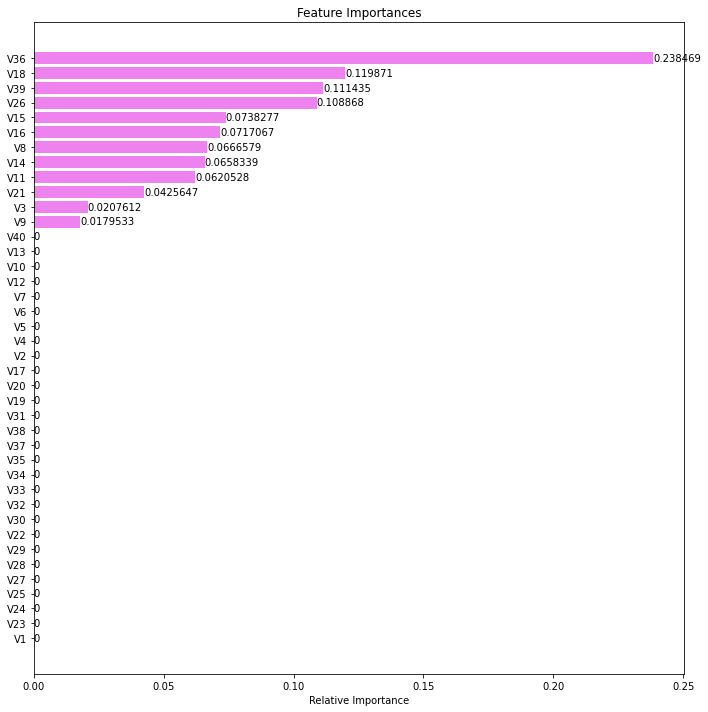

In [97]:
plot_feature_importance(tuned_xgb_under, x_train_un.columns)

#### Observations
- V36 is the most important feature with the tuned xgb under model.
- The top three most important features for the tuned xgb under are V36, V18 and V39.

## Check the performance on the test set.

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.678,0.904,0.139,0.241


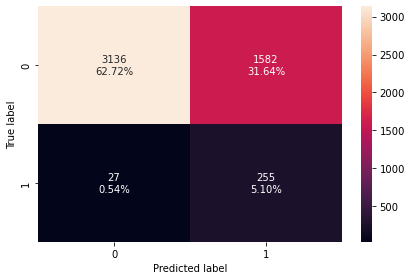

In [98]:
calculate_performance(tuned_xgb_under, x_test, y_test, model_testing_results, 'tuned xgb under')

#### Observations
- A recall of .904 on the test set confirms the tuned xgb under model is generalizable and is provided consistent results.

## Pipelines to build the final model


In [99]:
# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables.
# We only have numerical variables so need to have have a bifurcated column transformer.
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                     ("scale", StandardScaler())])

In [100]:
# Separating target variable and other variables
X1 = data.drop(columns="Target")
Y1 = data["Target"]

# Since we already have a separate test set, we don't need to divide data into train and test

x_test1 = df_test.drop(["Target"], axis=1)
y_test1 = df_test["Target"]

print(X1.shape, x_test1.shape, Y1.shape, y_test1.shape)

(20000, 40) (5000, 40) (20000,) (5000,)


In [101]:
# # code for undersampling on the data
# # Under Sampling Technique
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X1_train_un, Y1_train_un = rus.fit_resample(X1, Y1)

In [102]:
# Creating new pipeline with best parameters
parm_grid = {'random_state': 1, 'eval_metric': 'logloss',
            'subsample': 0.8,\
             'scale_pos_weight': 3.5, \
             'reg_lambda': 2.2857142857142856, \
             'n_estimators': 50,\
             'max_depth': 2,\
             'learning_rate': 0.05010204081632652,\
             'gamma': 4.877551020408164
            }

model = Pipeline(
    steps=[
        ("pre", numeric_transformer),
        (
            "XGB",
            XGBClassifier(**parm_grid),
        ),
    ]
)
# Fit the model on training data
model.fit(X1_train_un, Y1_train_un)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scale', StandardScaler())])),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=4.877...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.05010204081632652, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_d

Training Performance:


,Accuracy,Recall,Precision,F1
0,0.681,0.908,0.140,0.243


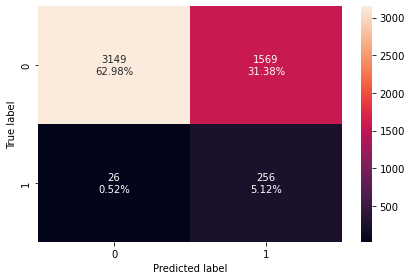

In [103]:
model_final_test_results = {}
calculate_performance(model, x_test1, y_test1, model_final_test_results, 'tuned final xgb', train=True)

#### Observations
- A recall of .908 on the pipeline test set confirms the tuned xgb under model is generalizable and is provided consistent results.

# Business Insights and Conclusions

## Actionable Insights and Recommendations
* The tuned_xgb_under is recommended model which has a test recall rate of .904 and a pipeline test recall rate of .908. This model is generalizable and is constructed to minimize False Negatives (real failures where there is no detection by the model) however it does struggle with False Positives (see <a id="cost_calculation">Cost Calculation<a>)
* V36 is the most important feature with the tuned xgb under model.
* The top three most important features for the tuned xgb under are V36, V18 and V39.

### Data Insights
* V32 has the highest maximum value of 23.63 while V16 has the lowest minimum value of -20.374 (in the training set).
* V3 has the highest mean value of 2.485 while V21 has the lowest mean value of -3.611 (in the training set).

#### Further analysis that can be done:
* Provide costs for repairs and inspection so that we can ensure the proper model for your business is selected going forward.
* Capture replacement date and MTBF data for sensors to further isolate potential areas of outages.

***